# Problem 2: Getting familiar with TensorFlow

*TensorFlow* is one of the most popular deep learning framework developed by Google. If you are new to TensorFlow, please read and play with the sample in [Getting started with TensorFlow](https://www.tensorflow.org/get_started/get_started) to get started.

* <b>Learning Objective:</b> In Problem 1, you implemented a fully connected network from scratch on your own. Very tedious to do it all by yourself, right? Well, we actually feel the same thing, that's why we are using tools instead of doing everything from scratch, lonely and depressed. For this part of the assignment, we will familiarize you with a widely-used deep learning framework developed by Google, TensorFlow and walk you through convolutional neural networks and show how to train them.
* <b>Provided Codes:</b> We provide the Template class for a simple CNN model as BaseModel, predefined skeletons for conv2d() and max_pool(), as well as the dataset preprocessing parts.
* <b>TODOs:</b> You are asked to implement the BaseModel following the detailed instrunctions and design your own model in YourModel to achieve a reasonably good performance for classification task on CIFAR-10 dataset.

## Install and import libraries
Install tensorflow and matplotlib.

```
pip install -U tensorflow matplotlib
```

In [3]:
# Import required libraries
# Add whatever you want
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

#print "TensorFlow Version {}".format(tf.__version__)

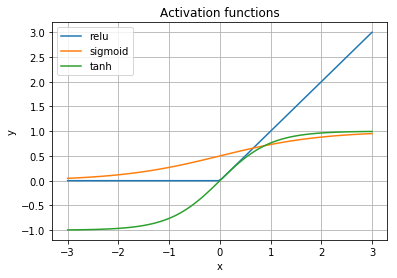

In [2]:
# Test matplotlib
x = np.linspace(-3, 3, 100)

plt.plot(x, np.maximum(0, x), label='relu')
plt.plot(x, 1/(1 + np.exp(-x)), label='sigmoid')
plt.plot(x, (1 - np.exp(-2 * x))/(1 + np.exp(-2 * x)), label='tanh')

plt.xlabel('x')
plt.ylabel('y')

plt.title("Activation functions")
plt.legend()
plt.grid(True)

plt.show()

In [3]:
# Test tensorflow
print('TensorFlow version: ' + tf.__version__)
a = tf.constant(2.0)
b = tf.constant(3.0)
c = a * b

sess = tf.Session()
result = sess.run([a, b, c])
print('%f * %f = %f' % (result[0], result[1], result[2]))
sess.close()

TensorFlow version: 1.3.0
2.000000 * 3.000000 = 6.000000


## Load datasets
Download [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz) and load the dataset. In this assignment, we will use all 50,000 images for training and 10,000 images for test.

In [4]:
# Configuration
num_training = 49000
num_validation = 50000 - num_training
num_test = 10000

def unpickle(file):
    import sys
    if sys.version_info.major == 2:
        import cPickle
        with open(file, 'rb') as fo:
            dict = cPickle.load(fo)
        return dict['data'], dict['labels']
    else:
        import pickle
        with open(file, 'rb') as fo:
            dict = pickle.load(fo, encoding='bytes')
        return dict[b'data'], dict[b'labels']

def load_train_data():
    
    #############################################################################
    # TODO: Load training data from cifar-10 dataset                            #
    # Load five files from 'data_batch_1' to 'data_batch_5'                     #
    # Reshape images and labels to the shape of [50000, 32, 32, 3]              # 
    # and [50000], respectively                                                 #
    #############################################################################
    path = 'cifar-10-batches-py/data_batch_'
    all_batches = []
    all_labels = []
    for b in range(1,6):
        data, label = unpickle(path + str(b))
        batch = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
        labels = np.array(label)
        all_batches.append(batch)
        all_labels.append(labels)
    data_train = np.concatenate(all_batches)
    labels_train = np.concatenate(all_labels)
    return data_train[:num_training, :, :, :], labels_train[:num_training], data_train[num_training:num_training + num_validation, :, :, :], labels_train[num_training:num_training + num_validation]
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

def load_test_data():
    

    #############################################################################
    # TODO: Load testing data from cifar-10 dataset                             #
    # Load 'test_batch' file                                                    #
    # Reshape images and labels to the shape of [10000, 32, 32, 3]              #
    # and [10000], respectively                                                 #
    #############################################################################
    path = 'cifar-10-batches-py/test_batch'
    data, label = unpickle(path)
    batch = data.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("float")
    labels = np.array(label)
    
    return batch, labels
    #############################################################################
    #                             END OF YOUR CODE                              #
    #############################################################################

# Load cifar-10 data
X_train, Y_train, X_val, Y_val = load_train_data()
X_test, Y_test = load_test_data()

# Check the shape of the dataset
assert X_train.shape == (num_training, 32, 32, 3)
assert Y_train.shape == (num_training, )
assert X_val.shape == (num_validation, 32, 32, 3)
assert Y_val.shape == (num_validation, )
assert X_test.shape == (num_test, 32, 32, 3)
assert Y_test.shape == (10000, )

## Question 2-1

Using the code provided, implement a neural network architecture with an optimization routine according to the specification provided below.

**Model:**
- Input image with the size 32x32x3
- 7x7 convolutional layer with 32 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- 5x5 convolutional layer with 64 filters, stride of 1, and padding 'SAME'
- ReLU activation layer
- 3x3 max pooling layer with a stride of 2
- Flatten layer (8x8x64 -> 4096)
- Fully-connected layer with 384 output units (4096 -> 384)
- ReLU activation layer
- Fully-connected layer with 10 output units (384 -> 10)
- Output logits (10)

**Optimizer:**
- Adam optimizer

**Learning rate:**
- Set start learning rate as 5e-4 and apply exponential decay every 500 steps with a base of 0.96
- Use 'tf.train.exponential_decay' and 'tf.train.AdamOptimizer'

**Loss:**
- Softmax cross entropy loss
- Use 'tf.nn.softmax_cross_entropy_with_logits'


Your model **should** achieve about 60% accuracy on validation set in 5 epochs using provided evaluation code.

You can modify the template code as you want.

## Define your layers

In [5]:
# Define max pooling and conv layers
def conv2d(input, kernel_size, stride, num_filter):
    stride_shape = [1, stride, stride, 1]
    filter_shape = [kernel_size, kernel_size, input.get_shape()[3], num_filter]

    W = tf.get_variable('w', filter_shape, tf.float32, tf.random_normal_initializer(0.0, 0.05))
    b = tf.get_variable('b', [1, 1, 1, num_filter], initializer=tf.constant_initializer(0.0))
    return tf.nn.conv2d(input, W, stride_shape, padding='SAME') + b

def max_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.max_pool(input, ksize=ksize, strides=strides, padding='SAME')

#############################################################################
# TODO: You can add any layers (fully-connected, normalization)             #
#############################################################################
def flatten(input):
    return tf.contrib.layers.flatten(input)

def fully_con(input, num_outputs):
    #flattened_shape = np.array(input.get_shape().as_list()[1:]).prod()
    W = tf.get_variable('w1', [input.get_shape()[1], num_outputs], tf.float32, tf.random_normal_initializer(0.0, 0.02))
    b = tf.get_variable('b1', [num_outputs], initializer=tf.constant_initializer(0.0))
    
    # Fully convolution layer.
    fc = tf.add(tf.matmul(input, W), b)  
    #tmp = tf.contrib.layers.xavier_initializer(uniform=True, seed=9999, dtype=tf.float32)
    #fc = tf.contrib.layers.fully_connected(input, num_outputs, activation_fn=None)
    return fc

def loss(logits, y):
    return tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y))

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

## Sample convolutional nueral network

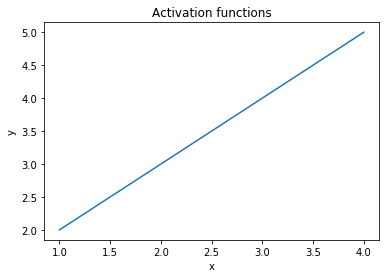

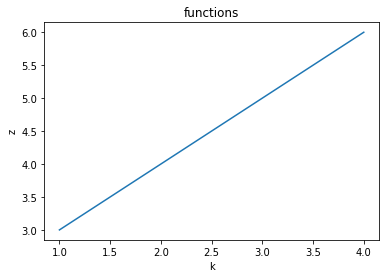

In [291]:
x = [1,2,3,4]
y1 = [2,3,4,5]
y2 = [3,4,5,6]
plt.figure(1)
plt.plot(x, y1)
plt.xlabel('x')
plt.ylabel('y')
plt.title("Activation functions")
plt.legend()
plt.figure(2)
plt.plot(x, y2)
plt.xlabel('k')
plt.ylabel('z')

plt.title("functions")
plt.legend()
plt.show()

In [6]:
class BaseModel(object):
    def __init__(self):
        self.num_epoch = 5
        self.batch_size = 128
        self.log_step = 50
        self._build_model()
    def _model(self):
        print('-' * 5 + '  Sample model  ' + '-' * 5)

        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 7, 1, 32)
            self.relu1 = tf.nn.relu(self.conv1)
            self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.pool1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.pool1, 5, 1, 64)
            self.relu2 = tf.nn.relu(self.conv2)
            self.pool2 = max_pool(self.relu2, 3, 2)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.pool2.get_shape()))


        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        self.flat = flatten(self.pool2)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        print('flat layer: ' + str(self.flat.get_shape()))

        with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc3 = fully_con(self.flat, 384)
            self.relu3 = tf.nn.relu(self.fc3)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc3 layer: ' + str(self.relu3.get_shape()))

        with tf.variable_scope('fc4'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.fc4 = fully_con(self.relu3, 10)
            #self.fc4 = tf.nn.relu(self.fc4)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('fc4 layer: ' + str(self.fc4.get_shape()))
        
        # Return the last layer
        return self.fc4

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #self.global_step = tf.placeholder(tf.int32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.global_step = tf.Variable(0, trainable=False)
        self.lr = tf.train.exponential_decay(5e-4, self.global_step, 500, 0.96, staircase=True)
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss_op, global_step=self.global_step)  
        #self.train_op = tf.train.AdamOptimizer().minimize(self.loss_op)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = loss(logits, labels)     
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {
                    self.X: X_,
                    self.Y: Y_,
                    self.keep_prob: 1.0
                }                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            plt.figure(1)
            plt.plot([x for x in range(len(losses))], losses)
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.title("Loss Chart")
            plt.legend()
            plt.figure(2)
            plt.plot([x for x in range(len(accuracies))], accuracies)
            plt.xlabel('iteration')
            plt.ylabel('accuracy')

            plt.title("Accuracy Chart")
            plt.legend()
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {
                self.X: X_,
                self.Y: Y_,
                self.keep_prob: 1.0
            }
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Sample model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 16, 16, 32)
conv2 layer: (?, 8, 8, 64)
flat layer: (?, 4096)
fc3 layer: (?, 384)
fc4 layer: (?, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 6.125, accuracy = 0.117
iteration (50): loss = 1.907, accuracy = 0.328
iteration (100): loss = 1.437, accuracy = 0.445
iteration (150): loss = 1.404, accuracy = 0.461
iteration (200): loss = 1.527, accuracy = 0.414
iteration (250): loss = 1.403, accuracy = 0.500
iteration (300): loss = 1.229, accuracy = 0.578
iteration (350): loss = 1.435, accuracy = 0.445


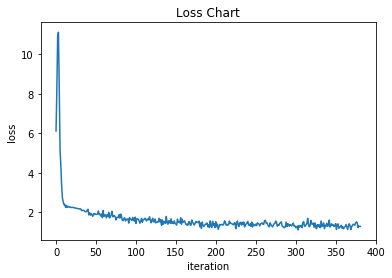

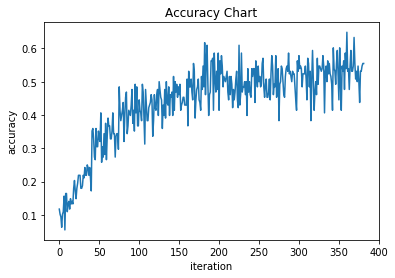

validation for epoch 0
-  epoch 0: validation accuracy = 0.575
train for epoch 1
iteration (400): loss = 1.254, accuracy = 0.562
iteration (450): loss = 1.258, accuracy = 0.539
iteration (500): loss = 1.243, accuracy = 0.539
iteration (550): loss = 1.104, accuracy = 0.633
iteration (600): loss = 1.135, accuracy = 0.609
iteration (650): loss = 1.377, accuracy = 0.516
iteration (700): loss = 1.047, accuracy = 0.656
iteration (750): loss = 1.137, accuracy = 0.648


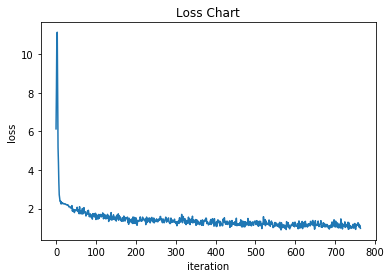

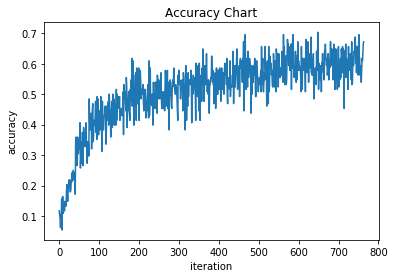

validation for epoch 1
-  epoch 1: validation accuracy = 0.610
train for epoch 2
iteration (800): loss = 0.926, accuracy = 0.641
iteration (850): loss = 1.157, accuracy = 0.594
iteration (900): loss = 0.930, accuracy = 0.672
iteration (950): loss = 0.818, accuracy = 0.719
iteration (1000): loss = 0.812, accuracy = 0.688
iteration (1050): loss = 0.966, accuracy = 0.648
iteration (1100): loss = 0.775, accuracy = 0.711


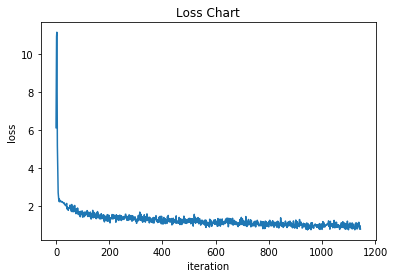

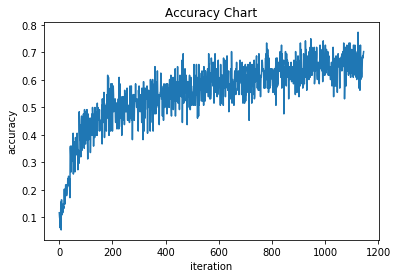

validation for epoch 2
-  epoch 2: validation accuracy = 0.622
train for epoch 3
iteration (1150): loss = 0.946, accuracy = 0.656
iteration (1200): loss = 0.839, accuracy = 0.648
iteration (1250): loss = 1.035, accuracy = 0.656
iteration (1300): loss = 1.061, accuracy = 0.578
iteration (1350): loss = 0.711, accuracy = 0.758
iteration (1400): loss = 0.880, accuracy = 0.750
iteration (1450): loss = 0.738, accuracy = 0.758
iteration (1500): loss = 0.778, accuracy = 0.711


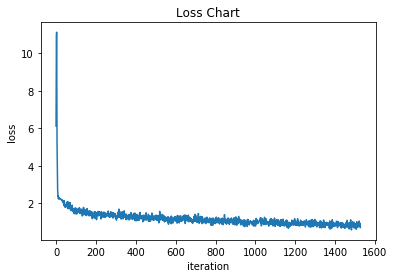

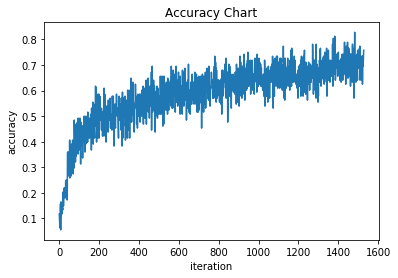

validation for epoch 3
-  epoch 3: validation accuracy = 0.615
train for epoch 4
iteration (1550): loss = 0.669, accuracy = 0.797
iteration (1600): loss = 0.786, accuracy = 0.719
iteration (1650): loss = 0.758, accuracy = 0.719
iteration (1700): loss = 0.740, accuracy = 0.750
iteration (1750): loss = 0.783, accuracy = 0.766
iteration (1800): loss = 0.658, accuracy = 0.797
iteration (1850): loss = 0.909, accuracy = 0.680
iteration (1900): loss = 0.630, accuracy = 0.789


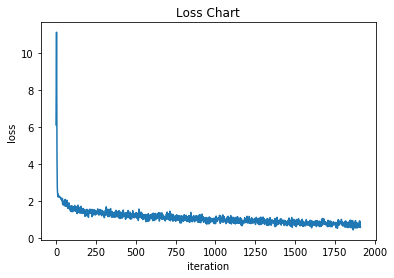

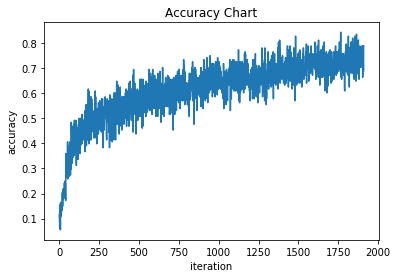

validation for epoch 4
-  epoch 4: validation accuracy = 0.604
***** test accuracy: 0.613
Model saved in lib/tf_models/problem2/csci-599_sample.ckpt


In [293]:
# Clear old computation graphs
tf.reset_default_graph()

# Train our sample model
with tf.Session() as sess:
    with tf.device('/cpu:0'):
        model = BaseModel()
        model.train(sess, X_train, Y_train, X_val, Y_val)
        accuracy = model.evaluate(sess, X_test, Y_test)
        print('***** test accuracy: %.3f' % accuracy)
        saver = tf.train.Saver()
        model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_sample.ckpt")
        print("Model saved in %s" % model_path)

## Question 2-2

Implement your own model. 

You can modify the template code as you want and you can use GPU for fast training.

These are the techniques that you can try:
- Data preprocessing
- Data augmentation
- Dropout
- Batch normalization
- More convolutional layers
- More training epochs
- Learning rate decay
- Any other models and techniqes

Your model should achieve >= 70% accuracy on the test set of CIFAR-10.

If the accuracy of the model reaches to 80% on the test set, you will get 5 extra points.

In [7]:
def avg_pool(input, kernel_size, stride):
    ksize = [1, kernel_size, kernel_size, 1]
    strides = [1, stride, stride, 1]
    return tf.nn.avg_pool(input, ksize=ksize, strides=strides, padding='SAME')

def normalize(x):
    ans = np.zeros(tuple(x.shape))
    cnt = x.shape[0]
    max_val, min_val = x.max(), x.min()
    for i in range(cnt):
        ans[i,...] = (x[i, ...] - float(min_val)) / float(max_val - min_val)
    return ans

In [8]:
class YourModel(object):#based on Network in Network model
    def __init__(self):
        super(YourModel, self).__init__()
        self.num_epoch = 100
        self.batch_size = 128
        self.log_step = 50
        self._build_model()
        
    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #self.global_step = tf.placeholder(tf.int32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
    
    def _model(self):
        print('-' * 5 + '  Your model  ' + '-' * 5)
        
        print('intput layer: ' + str(self.X.get_shape()))

        with tf.variable_scope('conv1'):
            self.conv1 = conv2d(self.X, 5, 1, 192)
            #self.conv1 = tf.nn.local_response_normalization(self.conv1)
            self.relu1 = tf.nn.relu(self.conv1)
            #self.pool1 = max_pool(self.relu1, 3, 2)            
            print('conv1 layer: ' + str(self.relu1.get_shape()))

        with tf.variable_scope('conv2'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv2 = conv2d(self.relu1, 1, 1, 160)
            #self.conv2 = tf.nn.local_response_normalization(self.conv2)
            self.relu2 = tf.nn.relu(self.conv2)
            #self.pool2 = max_pool(self.relu2, 3, 2)            
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv2 layer: ' + str(self.relu2.get_shape()))

        with tf.variable_scope('conv3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            self.conv3 = conv2d(self.relu2, 1, 1, 96)
            #self.conv3 = tf.nn.local_response_normalization(self.conv3)
            self.relu3 = tf.nn.relu(self.conv3)
            self.relu3 = max_pool(self.relu3, 3, 2)    
            self.relu3 = tf.nn.dropout(self.relu3, self.keep_prob)
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            print('conv3 layer: ' + str(self.relu3.get_shape()))
        
        with tf.variable_scope('conv4'):
            self.conv4 = conv2d(self.relu3, 5, 1, 192)
            self.relu4 = tf.nn.relu(self.conv4)
            print('conv4 layer: ' + str(self.relu4.get_shape()))
            
        with tf.variable_scope('conv5'):
            self.conv5 = conv2d(self.relu4, 1, 1, 192)
            self.relu5 = tf.nn.relu(self.conv5)
            print('conv5 layer: ' + str(self.relu5.get_shape()))
            
        with tf.variable_scope('conv6'):
            self.conv6 = conv2d(self.relu5, 1, 1, 192)
            self.relu6 = tf.nn.relu(self.conv6)
            self.relu6 = avg_pool(self.relu6, 3, 2)
            self.relu6 = tf.nn.dropout(self.relu6, self.keep_prob)
            print('conv6 layer: ' + str(self.relu6.get_shape()))
            
        with tf.variable_scope('conv7'):
            self.conv7 = conv2d(self.relu6, 3, 1, 192)
            self.relu7 = tf.nn.relu(self.conv7)
            print('conv7 layer: ' + str(self.relu7.get_shape()))
            
        with tf.variable_scope('conv8'):
            self.conv8 = conv2d(self.relu7, 1, 1, 192)
            self.relu8 = tf.nn.relu(self.conv8)
            print('conv8 layer: ' + str(self.relu8.get_shape()))
            
        with tf.variable_scope('conv9'):
            self.conv9 = conv2d(self.relu8, 1, 1, 10)
            self.relu9 = tf.nn.relu(self.conv9)
            self.relu9 = avg_pool(self.relu9, 8, 8)
            print('conv9 layer: ' + str(self.relu9.get_shape()))
        self.flat = flatten(self.relu9)
        return self.flat
        #############################################################################
        # TODO: Flatten the output tensor from conv2 layer                          #
        #############################################################################
        #self.flat = flatten(self.pool3)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################      
        #print('flat layer: ' + str(self.flat.get_shape()))

        #with tf.variable_scope('fc3'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            #self.fc3 = fully_con(self.flat, 384)
            #self.relu3 = tf.nn.relu(self.fc3)
            #self.relu3 = tf.nn.dropout(self.relu3, self.keep_prob) 
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            #print('fc3 layer: ' + str(self.relu3.get_shape()))

        #with tf.variable_scope('fc4'):
            #self.fc4 = fully_con(self.relu3, 192)
            #self.relu4 = tf.nn.relu(self.fc4)
            #self.dropout = tf.nn.dropout(self.relu4, self.keep_prob) 
            #print('fc4 layer: ' + str(self.dropout.get_shape()))
            
        #with tf.variable_scope('fc5'):
            #############################################################################
            # TODO: Complete the following functions                                    #
            #############################################################################
            #self.fc5 = fully_con(self.dropout, 10) 
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            #print('fc5 layer: ' + str(self.fc5.get_shape()))
        
        #return self.fc5

    def _input_ops(self):
        # Placeholders
        self.X = tf.placeholder(tf.float32, [None, 32, 32, 3])
        self.Y = tf.placeholder(tf.int64, [None])
        
        #############################################################################
        # TODO: You can add any placeholders                                        #
        #############################################################################
        self.is_train = tf.placeholder(tf.bool)
        self.keep_prob = tf.placeholder(tf.float32)
        #self.global_step = tf.placeholder(tf.int32)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_optimizer(self):
        # Adam optimizer 'self.train_op' that minimizes 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.global_step = tf.Variable(0, trainable=False)
        self.lr = tf.train.exponential_decay(5e-4, self.global_step, 500, 0.96)
        self.train_op = tf.train.AdamOptimizer(self.lr).minimize(self.loss_op, global_step=self.global_step)  
        #self.train_op = tf.train.AdamOptimizer().minimize(self.loss_op)
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def _loss(self, labels, logits):
        # Softmax cross entropy loss 'self.loss_op'
        #############################################################################
        # TODO: Complete the following functions                                    #
        #############################################################################
        self.loss_op = loss(logits, labels)     
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def _build_model(self):
        # Define input variables
        self._input_ops()

        # Convert Y to one-hot vector
        labels = tf.one_hot(self.Y, 10)

        # Build a model and get logits
        logits = self._model()

        # Compute loss
        self._loss(labels, logits)
        
        # Build optimizer
        self._build_optimizer()

        # Compute accuracy
        predict = tf.argmax(logits, 1)
        correct = tf.equal(predict, self.Y)
        self.accuracy_op = tf.reduce_mean(tf.cast(correct, tf.float32))
        
    def train(self, sess, X_train, Y_train, X_val, Y_val):
        sess.run(tf.global_variables_initializer())

        step = 0
        losses = []
        accuracies = []
        print('-' * 5 + '  Start training  ' + '-' * 5)
        for epoch in range(self.num_epoch):
            print('train for epoch %d' % epoch)
            for i in range(num_training // self.batch_size):
                X_ = X_train[i * self.batch_size:(i + 1) * self.batch_size][:]
                Y_ = Y_train[i * self.batch_size:(i + 1) * self.batch_size]

                #############################################################################
                # TODO: You can change feed data as you want                                #
                #############################################################################
                feed_dict = {
                    self.X: X_,
                    self.Y: Y_,
                    self.keep_prob: 0.5
                }                
                #############################################################################
                #                             END OF YOUR CODE                              #
                #############################################################################
                fetches = [self.train_op, self.loss_op, self.accuracy_op]

                _, loss, accuracy = sess.run(fetches, feed_dict=feed_dict)
                losses.append(loss)
                accuracies.append(accuracy)

                if step % self.log_step == 0:
                    print('iteration (%d): loss = %.3f, accuracy = %.3f' %
                        (step, loss, accuracy))
                step += 1

            #############################################################################
            # TODO: Plot training curves                                                #
            #############################################################################
            plt.figure(1)
            plt.plot([x for x in range(len(losses))], losses)
            plt.xlabel('iteration')
            plt.ylabel('loss')
            plt.title("Loss Chart")
            plt.legend()
            plt.figure(2)
            plt.plot([x for x in range(len(accuracies))], accuracies)
            plt.xlabel('iteration')
            plt.ylabel('accuracy')

            plt.title("Accuracy Chart")
            plt.legend()
            plt.show()
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################

            # Print validation results
            print('validation for epoch %d' % epoch)
            val_accuracy = self.evaluate(sess, X_val, Y_val)
            print('-  epoch %d: validation accuracy = %.3f' % (epoch, val_accuracy))

    def evaluate(self, sess, X_eval, Y_eval):
        eval_accuracy = 0.0
        eval_iter = 0
        for i in range(X_eval.shape[0] // self.batch_size):
            X_ = X_eval[i * self.batch_size:(i + 1) * self.batch_size][:]
            Y_ = Y_eval[i * self.batch_size:(i + 1) * self.batch_size]
                        
            #############################################################################
            # TODO: You can change feed data as you want                                #
            #############################################################################
            feed_dict = {
                self.X: X_,
                self.Y: Y_,
                self.keep_prob: 1.0
            }
            #############################################################################
            #                             END OF YOUR CODE                              #
            #############################################################################
            accuracy = sess.run(self.accuracy_op, feed_dict=feed_dict)
            eval_accuracy += accuracy
            eval_iter += 1
        return eval_accuracy / eval_iter

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 192)
conv2 layer: (?, 32, 32, 160)
conv3 layer: (?, 16, 16, 96)
conv4 layer: (?, 16, 16, 192)
conv5 layer: (?, 16, 16, 192)
conv6 layer: (?, 8, 8, 192)
conv7 layer: (?, 8, 8, 192)
conv8 layer: (?, 8, 8, 192)
conv9 layer: (?, 1, 1, 10)
-----  Start training  -----
train for epoch 0
iteration (0): loss = 2.303, accuracy = 0.102
iteration (50): loss = 2.257, accuracy = 0.125
iteration (100): loss = 2.103, accuracy = 0.227
iteration (150): loss = 2.146, accuracy = 0.180
iteration (200): loss = 2.135, accuracy = 0.305
iteration (250): loss = 2.014, accuracy = 0.227
iteration (300): loss = 1.873, accuracy = 0.312
iteration (350): loss = 1.851, accuracy = 0.320


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


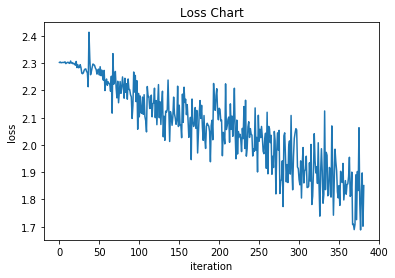

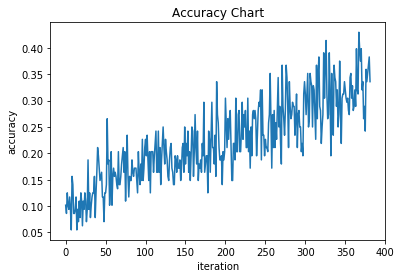

validation for epoch 0
-  epoch 0: validation accuracy = 0.360
train for epoch 1
iteration (400): loss = 1.750, accuracy = 0.406
iteration (450): loss = 1.936, accuracy = 0.367
iteration (500): loss = 1.882, accuracy = 0.297
iteration (550): loss = 1.684, accuracy = 0.375
iteration (600): loss = 1.626, accuracy = 0.484
iteration (650): loss = 1.570, accuracy = 0.469
iteration (700): loss = 1.623, accuracy = 0.438
iteration (750): loss = 1.428, accuracy = 0.508


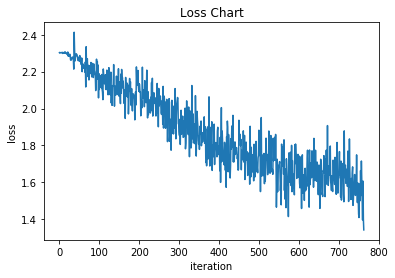

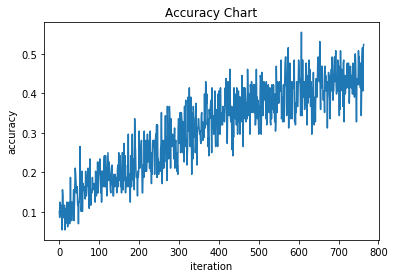

validation for epoch 1
-  epoch 1: validation accuracy = 0.470
train for epoch 2
iteration (800): loss = 1.321, accuracy = 0.477
iteration (850): loss = 1.540, accuracy = 0.414
iteration (900): loss = 1.406, accuracy = 0.453
iteration (950): loss = 1.286, accuracy = 0.547
iteration (1000): loss = 1.504, accuracy = 0.391
iteration (1050): loss = 1.272, accuracy = 0.508
iteration (1100): loss = 1.246, accuracy = 0.508


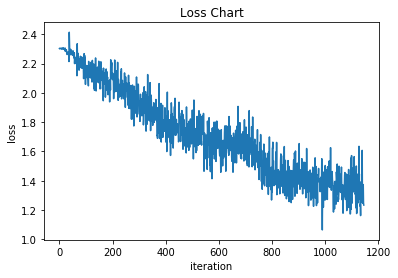

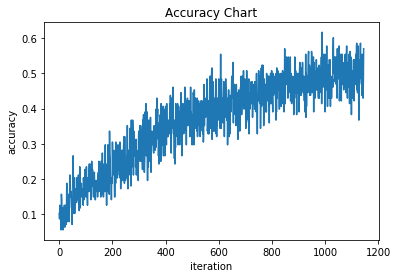

validation for epoch 2
-  epoch 2: validation accuracy = 0.521
train for epoch 3
iteration (1150): loss = 1.229, accuracy = 0.594
iteration (1200): loss = 1.185, accuracy = 0.555
iteration (1250): loss = 1.318, accuracy = 0.539
iteration (1300): loss = 1.340, accuracy = 0.477
iteration (1350): loss = 1.159, accuracy = 0.578
iteration (1400): loss = 1.265, accuracy = 0.523
iteration (1450): loss = 1.288, accuracy = 0.492
iteration (1500): loss = 1.081, accuracy = 0.602


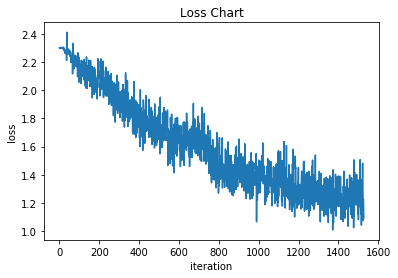

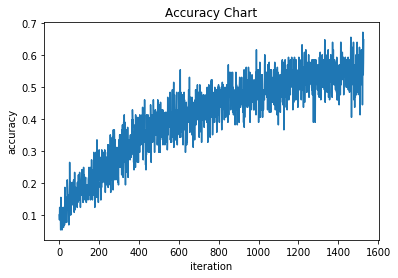

validation for epoch 3
-  epoch 3: validation accuracy = 0.580
train for epoch 4
iteration (1550): loss = 1.039, accuracy = 0.609
iteration (1600): loss = 1.089, accuracy = 0.633
iteration (1650): loss = 1.122, accuracy = 0.641
iteration (1700): loss = 1.078, accuracy = 0.641
iteration (1750): loss = 1.210, accuracy = 0.594
iteration (1800): loss = 1.188, accuracy = 0.562
iteration (1850): loss = 1.208, accuracy = 0.555
iteration (1900): loss = 1.177, accuracy = 0.555


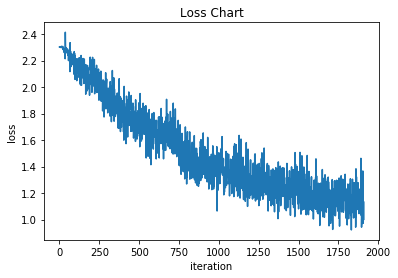

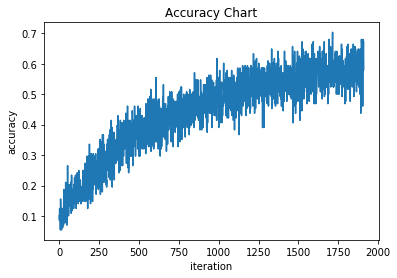

validation for epoch 4
-  epoch 4: validation accuracy = 0.615
train for epoch 5
iteration (1950): loss = 1.277, accuracy = 0.539
iteration (2000): loss = 0.997, accuracy = 0.617
iteration (2050): loss = 1.088, accuracy = 0.594
iteration (2100): loss = 1.002, accuracy = 0.672
iteration (2150): loss = 1.211, accuracy = 0.570
iteration (2200): loss = 1.122, accuracy = 0.594
iteration (2250): loss = 1.024, accuracy = 0.594


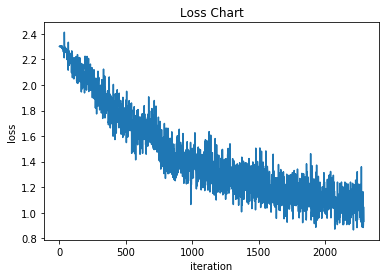

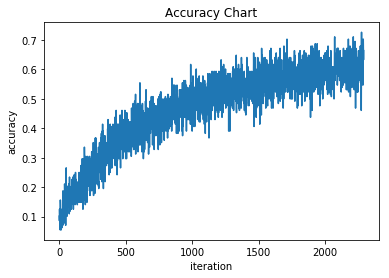

validation for epoch 5
-  epoch 5: validation accuracy = 0.644
train for epoch 6
iteration (2300): loss = 0.992, accuracy = 0.648
iteration (2350): loss = 1.024, accuracy = 0.695
iteration (2400): loss = 1.050, accuracy = 0.609
iteration (2450): loss = 1.136, accuracy = 0.570
iteration (2500): loss = 1.014, accuracy = 0.617
iteration (2550): loss = 1.108, accuracy = 0.547
iteration (2600): loss = 1.030, accuracy = 0.578
iteration (2650): loss = 1.004, accuracy = 0.547


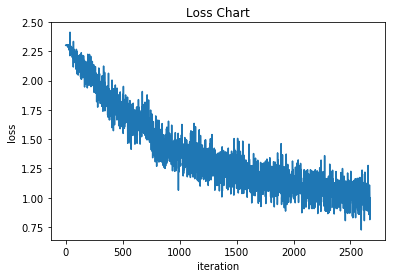

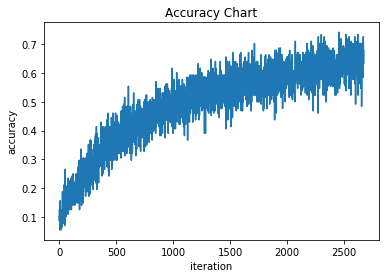

validation for epoch 6
-  epoch 6: validation accuracy = 0.655
train for epoch 7
iteration (2700): loss = 1.246, accuracy = 0.586
iteration (2750): loss = 0.971, accuracy = 0.656
iteration (2800): loss = 1.010, accuracy = 0.664
iteration (2850): loss = 0.872, accuracy = 0.664
iteration (2900): loss = 0.935, accuracy = 0.664
iteration (2950): loss = 0.869, accuracy = 0.625
iteration (3000): loss = 0.900, accuracy = 0.672
iteration (3050): loss = 0.969, accuracy = 0.688


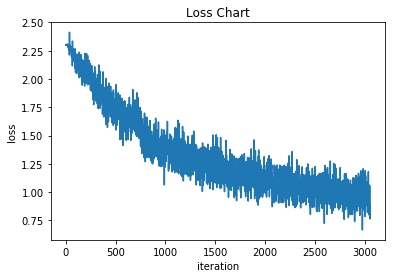

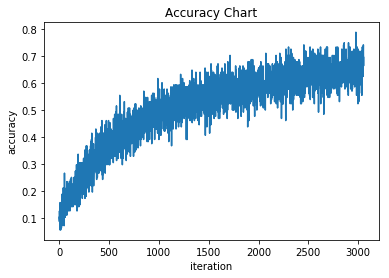

validation for epoch 7
-  epoch 7: validation accuracy = 0.679
train for epoch 8
iteration (3100): loss = 1.048, accuracy = 0.562
iteration (3150): loss = 1.061, accuracy = 0.586
iteration (3200): loss = 1.002, accuracy = 0.633
iteration (3250): loss = 0.913, accuracy = 0.617
iteration (3300): loss = 0.845, accuracy = 0.758
iteration (3350): loss = 0.941, accuracy = 0.641
iteration (3400): loss = 0.836, accuracy = 0.711


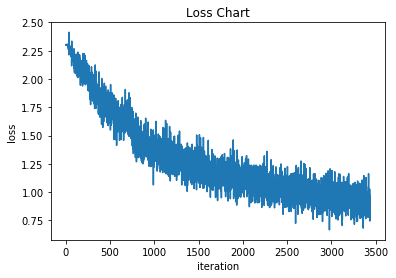

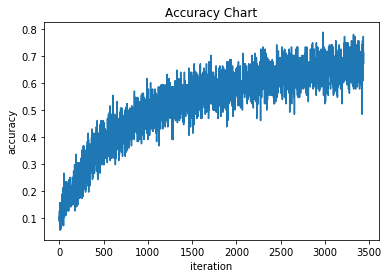

validation for epoch 8
-  epoch 8: validation accuracy = 0.698
train for epoch 9
iteration (3450): loss = 0.895, accuracy = 0.680
iteration (3500): loss = 0.906, accuracy = 0.680
iteration (3550): loss = 0.929, accuracy = 0.680
iteration (3600): loss = 0.720, accuracy = 0.773
iteration (3650): loss = 0.941, accuracy = 0.672
iteration (3700): loss = 0.899, accuracy = 0.625
iteration (3750): loss = 0.838, accuracy = 0.742
iteration (3800): loss = 0.800, accuracy = 0.727


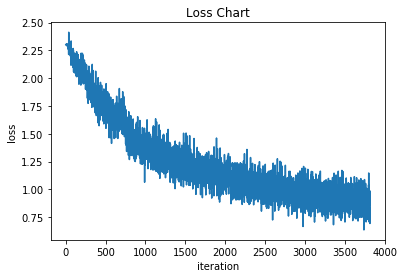

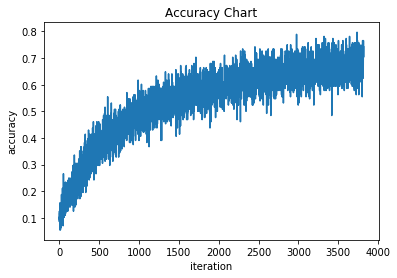

validation for epoch 9
-  epoch 9: validation accuracy = 0.696
train for epoch 10
iteration (3850): loss = 0.897, accuracy = 0.711
iteration (3900): loss = 0.843, accuracy = 0.688
iteration (3950): loss = 0.787, accuracy = 0.695
iteration (4000): loss = 0.889, accuracy = 0.742
iteration (4050): loss = 0.736, accuracy = 0.727
iteration (4100): loss = 0.738, accuracy = 0.758
iteration (4150): loss = 0.727, accuracy = 0.750
iteration (4200): loss = 0.772, accuracy = 0.742


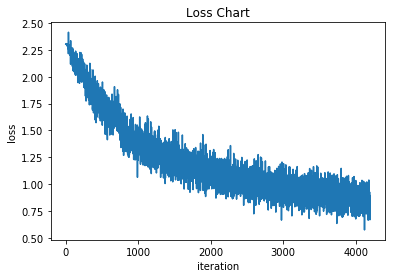

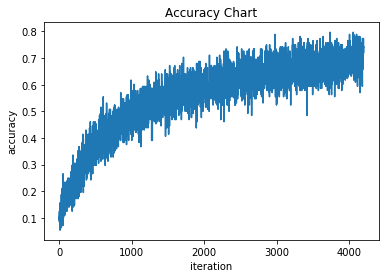

validation for epoch 10
-  epoch 10: validation accuracy = 0.711
train for epoch 11
iteration (4250): loss = 0.804, accuracy = 0.734
iteration (4300): loss = 0.861, accuracy = 0.680
iteration (4350): loss = 0.875, accuracy = 0.656
iteration (4400): loss = 0.877, accuracy = 0.680
iteration (4450): loss = 0.923, accuracy = 0.672
iteration (4500): loss = 0.760, accuracy = 0.742
iteration (4550): loss = 0.783, accuracy = 0.742


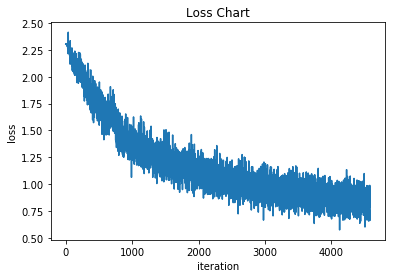

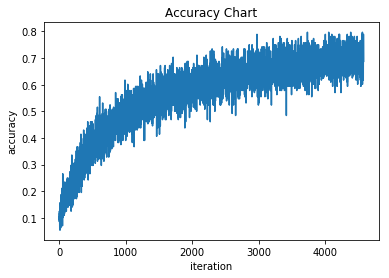

validation for epoch 11
-  epoch 11: validation accuracy = 0.721
train for epoch 12
iteration (4600): loss = 0.726, accuracy = 0.750
iteration (4650): loss = 0.861, accuracy = 0.672
iteration (4700): loss = 0.900, accuracy = 0.664
iteration (4750): loss = 0.824, accuracy = 0.750
iteration (4800): loss = 0.762, accuracy = 0.734
iteration (4850): loss = 0.736, accuracy = 0.758
iteration (4900): loss = 0.881, accuracy = 0.742
iteration (4950): loss = 0.773, accuracy = 0.719


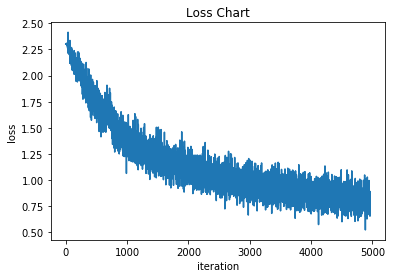

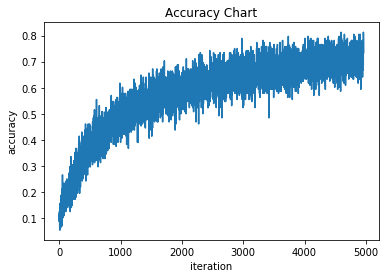

validation for epoch 12
-  epoch 12: validation accuracy = 0.731
train for epoch 13
iteration (5000): loss = 0.661, accuracy = 0.805
iteration (5050): loss = 0.733, accuracy = 0.719
iteration (5100): loss = 0.629, accuracy = 0.734
iteration (5150): loss = 0.825, accuracy = 0.711
iteration (5200): loss = 0.806, accuracy = 0.734
iteration (5250): loss = 0.708, accuracy = 0.734
iteration (5300): loss = 0.659, accuracy = 0.781


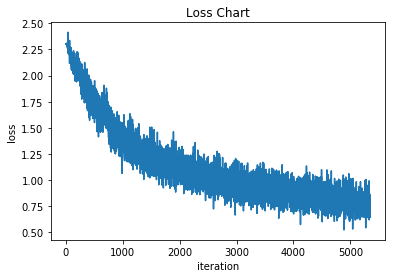

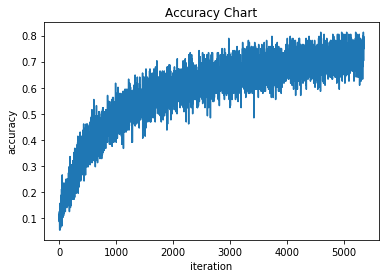

validation for epoch 13
-  epoch 13: validation accuracy = 0.733
train for epoch 14
iteration (5350): loss = 0.754, accuracy = 0.727
iteration (5400): loss = 0.905, accuracy = 0.672
iteration (5450): loss = 0.746, accuracy = 0.711
iteration (5500): loss = 0.796, accuracy = 0.680
iteration (5550): loss = 0.808, accuracy = 0.711
iteration (5600): loss = 0.684, accuracy = 0.758
iteration (5650): loss = 0.660, accuracy = 0.766
iteration (5700): loss = 0.771, accuracy = 0.742


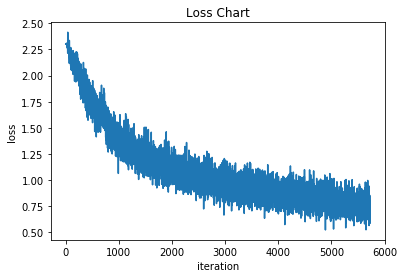

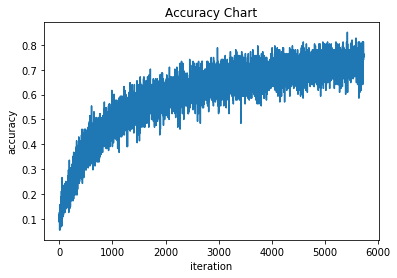

validation for epoch 14
-  epoch 14: validation accuracy = 0.759
train for epoch 15
iteration (5750): loss = 0.562, accuracy = 0.781
iteration (5800): loss = 0.749, accuracy = 0.750
iteration (5850): loss = 0.653, accuracy = 0.766
iteration (5900): loss = 0.637, accuracy = 0.781
iteration (5950): loss = 0.680, accuracy = 0.711
iteration (6000): loss = 0.730, accuracy = 0.727
iteration (6050): loss = 0.726, accuracy = 0.742
iteration (6100): loss = 0.712, accuracy = 0.727


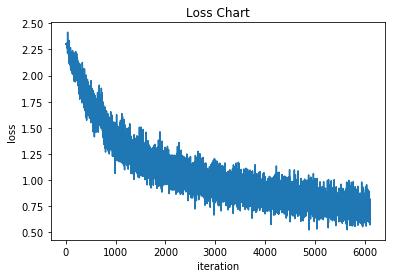

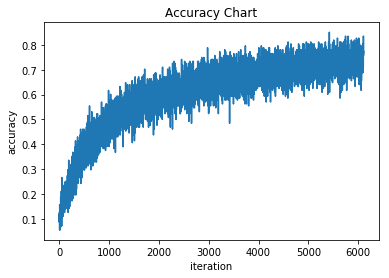

validation for epoch 15
-  epoch 15: validation accuracy = 0.766
train for epoch 16
iteration (6150): loss = 0.844, accuracy = 0.758
iteration (6200): loss = 0.747, accuracy = 0.711
iteration (6250): loss = 0.906, accuracy = 0.664
iteration (6300): loss = 0.609, accuracy = 0.742
iteration (6350): loss = 0.755, accuracy = 0.766
iteration (6400): loss = 0.875, accuracy = 0.672
iteration (6450): loss = 0.745, accuracy = 0.719


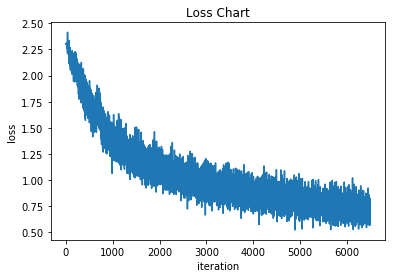

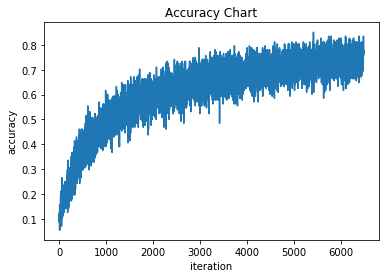

validation for epoch 16
-  epoch 16: validation accuracy = 0.752
train for epoch 17
iteration (6500): loss = 0.713, accuracy = 0.734
iteration (6550): loss = 0.627, accuracy = 0.773
iteration (6600): loss = 0.704, accuracy = 0.750
iteration (6650): loss = 0.836, accuracy = 0.688
iteration (6700): loss = 0.637, accuracy = 0.781
iteration (6750): loss = 0.781, accuracy = 0.734
iteration (6800): loss = 0.580, accuracy = 0.805
iteration (6850): loss = 0.655, accuracy = 0.789


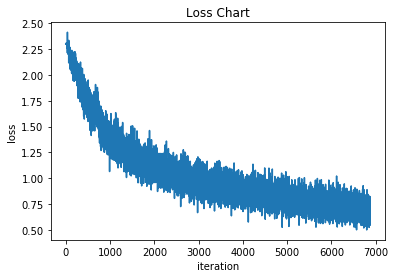

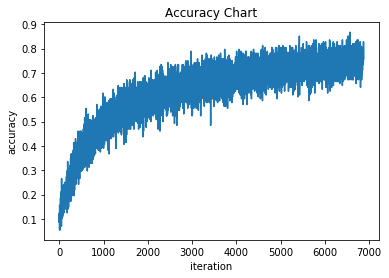

validation for epoch 17
-  epoch 17: validation accuracy = 0.772
train for epoch 18
iteration (6900): loss = 0.603, accuracy = 0.773
iteration (6950): loss = 0.478, accuracy = 0.836
iteration (7000): loss = 0.678, accuracy = 0.750
iteration (7050): loss = 0.648, accuracy = 0.734
iteration (7100): loss = 0.855, accuracy = 0.664
iteration (7150): loss = 0.629, accuracy = 0.789
iteration (7200): loss = 0.861, accuracy = 0.711
iteration (7250): loss = 0.720, accuracy = 0.742


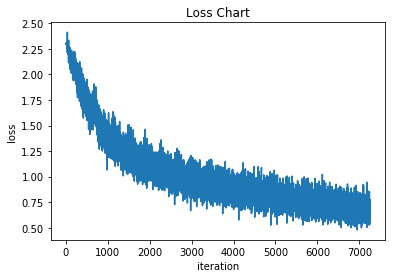

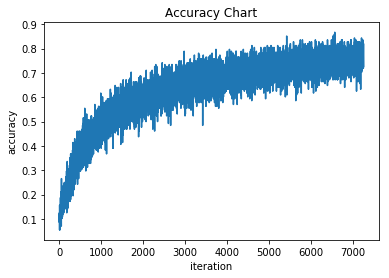

validation for epoch 18
-  epoch 18: validation accuracy = 0.765
train for epoch 19
iteration (7300): loss = 0.847, accuracy = 0.703
iteration (7350): loss = 0.819, accuracy = 0.719
iteration (7400): loss = 0.726, accuracy = 0.742
iteration (7450): loss = 0.615, accuracy = 0.773
iteration (7500): loss = 0.619, accuracy = 0.758
iteration (7550): loss = 0.581, accuracy = 0.750
iteration (7600): loss = 0.629, accuracy = 0.781


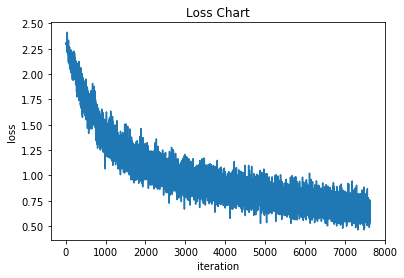

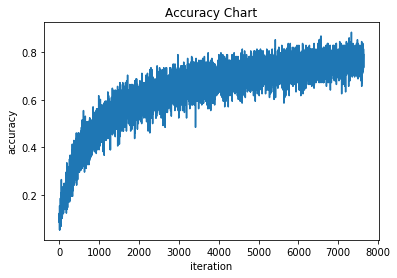

validation for epoch 19
-  epoch 19: validation accuracy = 0.787
train for epoch 20
iteration (7650): loss = 0.725, accuracy = 0.766
iteration (7700): loss = 0.528, accuracy = 0.820
iteration (7750): loss = 0.638, accuracy = 0.773
iteration (7800): loss = 0.617, accuracy = 0.789
iteration (7850): loss = 0.638, accuracy = 0.773
iteration (7900): loss = 0.713, accuracy = 0.703
iteration (7950): loss = 0.813, accuracy = 0.672
iteration (8000): loss = 0.469, accuracy = 0.812


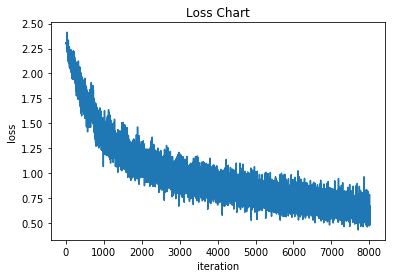

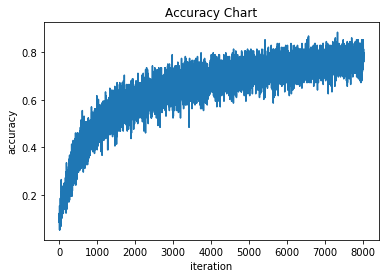

validation for epoch 20
-  epoch 20: validation accuracy = 0.787
train for epoch 21
iteration (8050): loss = 0.518, accuracy = 0.859
iteration (8100): loss = 0.501, accuracy = 0.836
iteration (8150): loss = 0.822, accuracy = 0.711
iteration (8200): loss = 0.734, accuracy = 0.688
iteration (8250): loss = 0.573, accuracy = 0.805
iteration (8300): loss = 0.548, accuracy = 0.812
iteration (8350): loss = 0.684, accuracy = 0.766
iteration (8400): loss = 0.464, accuracy = 0.828


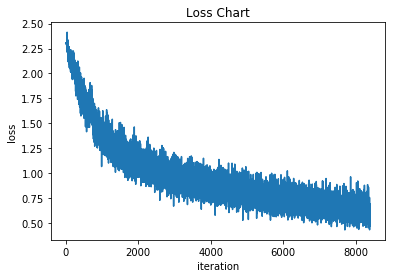

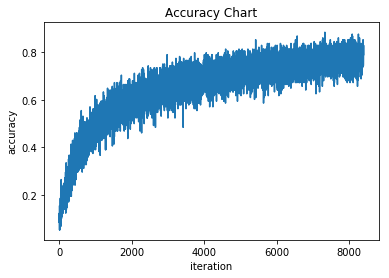

validation for epoch 21
-  epoch 21: validation accuracy = 0.794
train for epoch 22
iteration (8450): loss = 0.585, accuracy = 0.805
iteration (8500): loss = 0.683, accuracy = 0.711
iteration (8550): loss = 0.612, accuracy = 0.766
iteration (8600): loss = 0.519, accuracy = 0.789
iteration (8650): loss = 0.627, accuracy = 0.820
iteration (8700): loss = 0.593, accuracy = 0.781
iteration (8750): loss = 0.596, accuracy = 0.773


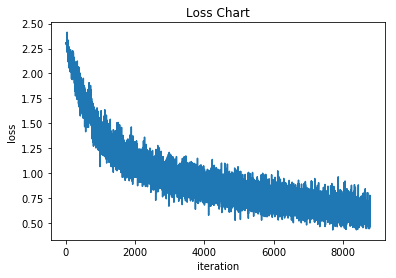

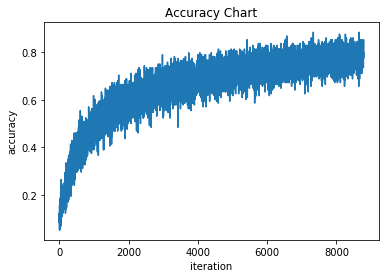

validation for epoch 22
-  epoch 22: validation accuracy = 0.795
train for epoch 23
iteration (8800): loss = 0.556, accuracy = 0.820
iteration (8850): loss = 0.660, accuracy = 0.805
iteration (8900): loss = 0.624, accuracy = 0.750
iteration (8950): loss = 0.675, accuracy = 0.789
iteration (9000): loss = 0.656, accuracy = 0.773
iteration (9050): loss = 0.670, accuracy = 0.727
iteration (9100): loss = 0.560, accuracy = 0.781
iteration (9150): loss = 0.513, accuracy = 0.805


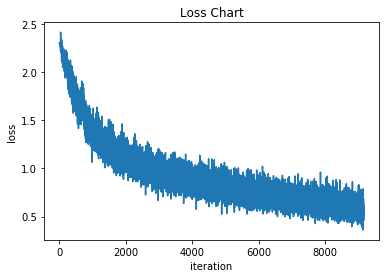

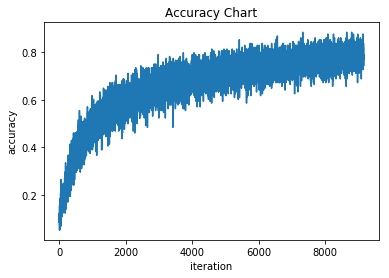

validation for epoch 23
-  epoch 23: validation accuracy = 0.800
train for epoch 24
iteration (9200): loss = 0.683, accuracy = 0.789
iteration (9250): loss = 0.585, accuracy = 0.773
iteration (9300): loss = 0.610, accuracy = 0.758
iteration (9350): loss = 0.498, accuracy = 0.820
iteration (9400): loss = 0.530, accuracy = 0.805
iteration (9450): loss = 0.566, accuracy = 0.773
iteration (9500): loss = 0.697, accuracy = 0.742


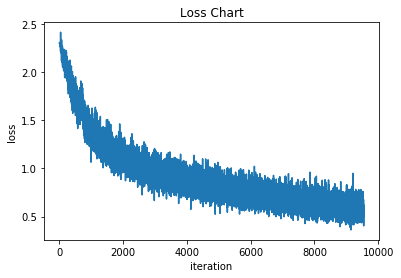

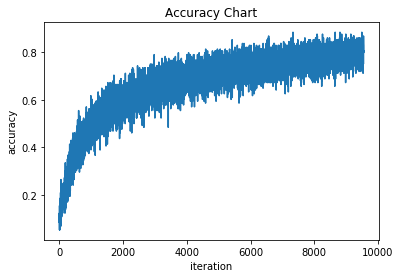

validation for epoch 24
-  epoch 24: validation accuracy = 0.799
train for epoch 25
iteration (9550): loss = 0.533, accuracy = 0.820
iteration (9600): loss = 0.561, accuracy = 0.797
iteration (9650): loss = 0.491, accuracy = 0.812
iteration (9700): loss = 0.684, accuracy = 0.773
iteration (9750): loss = 0.637, accuracy = 0.789
iteration (9800): loss = 0.621, accuracy = 0.766
iteration (9850): loss = 0.531, accuracy = 0.820
iteration (9900): loss = 0.651, accuracy = 0.742


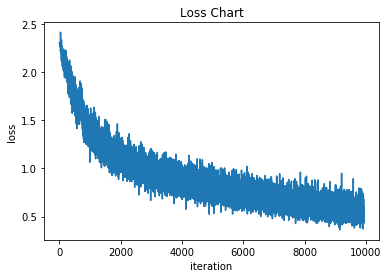

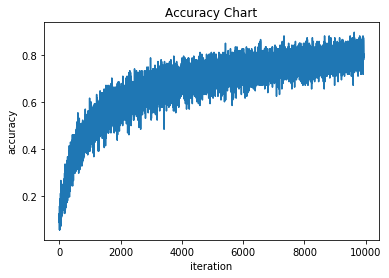

validation for epoch 25
-  epoch 25: validation accuracy = 0.809
train for epoch 26
iteration (9950): loss = 0.548, accuracy = 0.805
iteration (10000): loss = 0.483, accuracy = 0.836
iteration (10050): loss = 0.629, accuracy = 0.766
iteration (10100): loss = 0.638, accuracy = 0.758
iteration (10150): loss = 0.567, accuracy = 0.805
iteration (10200): loss = 0.585, accuracy = 0.805
iteration (10250): loss = 0.542, accuracy = 0.852
iteration (10300): loss = 0.476, accuracy = 0.836


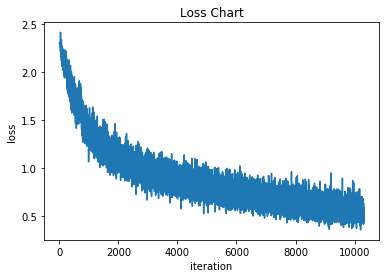

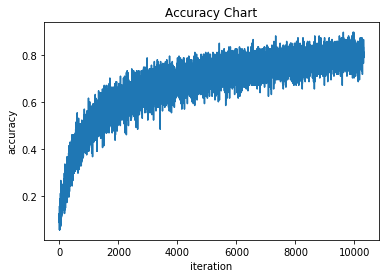

validation for epoch 26
-  epoch 26: validation accuracy = 0.812
train for epoch 27
iteration (10350): loss = 0.506, accuracy = 0.812
iteration (10400): loss = 0.562, accuracy = 0.797
iteration (10450): loss = 0.539, accuracy = 0.797
iteration (10500): loss = 0.533, accuracy = 0.836
iteration (10550): loss = 0.432, accuracy = 0.867
iteration (10600): loss = 0.543, accuracy = 0.766
iteration (10650): loss = 0.548, accuracy = 0.812


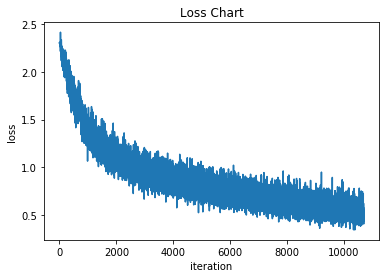

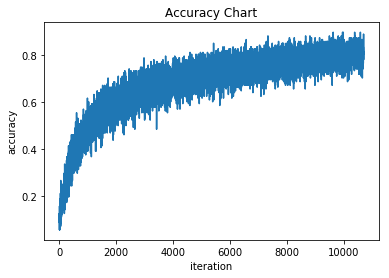

validation for epoch 27
-  epoch 27: validation accuracy = 0.804
train for epoch 28
iteration (10700): loss = 0.497, accuracy = 0.844
iteration (10750): loss = 0.405, accuracy = 0.844
iteration (10800): loss = 0.535, accuracy = 0.859
iteration (10850): loss = 0.596, accuracy = 0.797
iteration (10900): loss = 0.471, accuracy = 0.828
iteration (10950): loss = 0.633, accuracy = 0.828
iteration (11000): loss = 0.542, accuracy = 0.758
iteration (11050): loss = 0.406, accuracy = 0.859


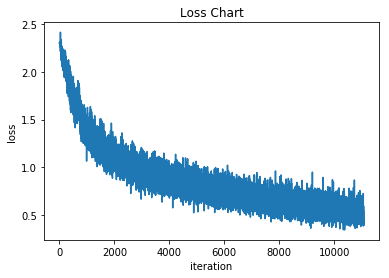

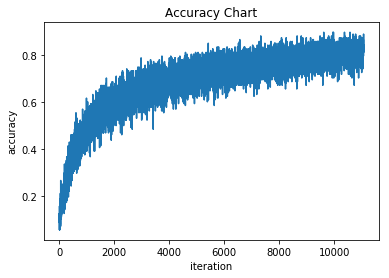

validation for epoch 28
-  epoch 28: validation accuracy = 0.804
train for epoch 29
iteration (11100): loss = 0.479, accuracy = 0.844
iteration (11150): loss = 0.568, accuracy = 0.789
iteration (11200): loss = 0.613, accuracy = 0.805
iteration (11250): loss = 0.431, accuracy = 0.805
iteration (11300): loss = 0.662, accuracy = 0.773
iteration (11350): loss = 0.372, accuracy = 0.883
iteration (11400): loss = 0.516, accuracy = 0.797
iteration (11450): loss = 0.542, accuracy = 0.805


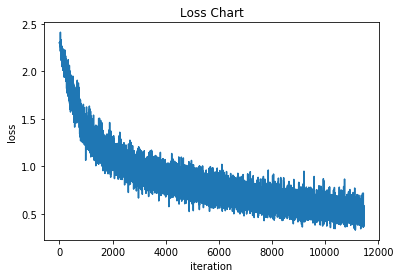

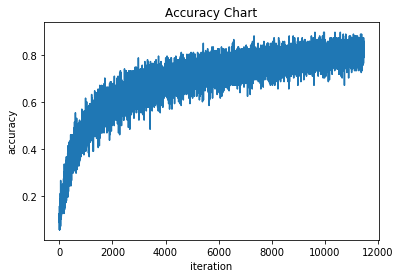

validation for epoch 29
-  epoch 29: validation accuracy = 0.806
train for epoch 30
iteration (11500): loss = 0.573, accuracy = 0.758
iteration (11550): loss = 0.415, accuracy = 0.836
iteration (11600): loss = 0.507, accuracy = 0.797
iteration (11650): loss = 0.680, accuracy = 0.773
iteration (11700): loss = 0.696, accuracy = 0.766
iteration (11750): loss = 0.599, accuracy = 0.789
iteration (11800): loss = 0.445, accuracy = 0.859


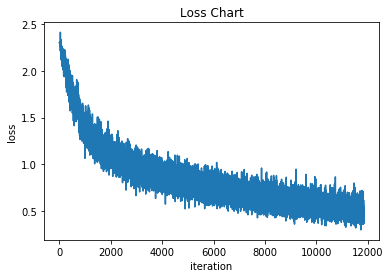

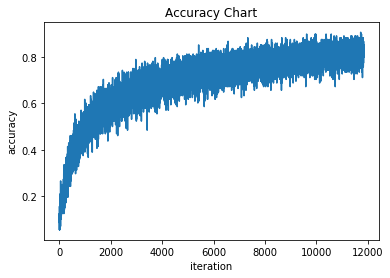

validation for epoch 30
-  epoch 30: validation accuracy = 0.811
train for epoch 31
iteration (11850): loss = 0.535, accuracy = 0.781
iteration (11900): loss = 0.407, accuracy = 0.820
iteration (11950): loss = 0.608, accuracy = 0.773
iteration (12000): loss = 0.530, accuracy = 0.812
iteration (12050): loss = 0.526, accuracy = 0.836
iteration (12100): loss = 0.577, accuracy = 0.820
iteration (12150): loss = 0.457, accuracy = 0.820
iteration (12200): loss = 0.473, accuracy = 0.836


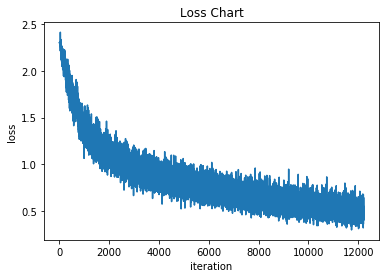

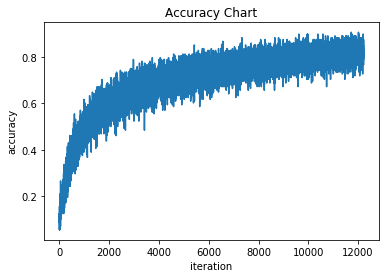

validation for epoch 31
-  epoch 31: validation accuracy = 0.809
train for epoch 32
iteration (12250): loss = 0.625, accuracy = 0.781
iteration (12300): loss = 0.589, accuracy = 0.805
iteration (12350): loss = 0.483, accuracy = 0.812
iteration (12400): loss = 0.452, accuracy = 0.867
iteration (12450): loss = 0.438, accuracy = 0.852
iteration (12500): loss = 0.368, accuracy = 0.859
iteration (12550): loss = 0.469, accuracy = 0.852
iteration (12600): loss = 0.459, accuracy = 0.875


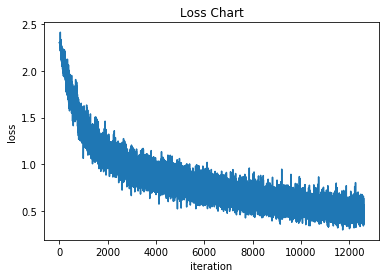

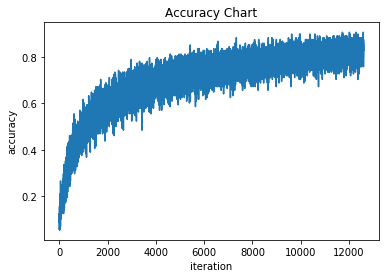

validation for epoch 32
-  epoch 32: validation accuracy = 0.809
train for epoch 33
iteration (12650): loss = 0.536, accuracy = 0.820
iteration (12700): loss = 0.492, accuracy = 0.805
iteration (12750): loss = 0.661, accuracy = 0.758
iteration (12800): loss = 0.584, accuracy = 0.781
iteration (12850): loss = 0.433, accuracy = 0.844
iteration (12900): loss = 0.568, accuracy = 0.820
iteration (12950): loss = 0.393, accuracy = 0.867


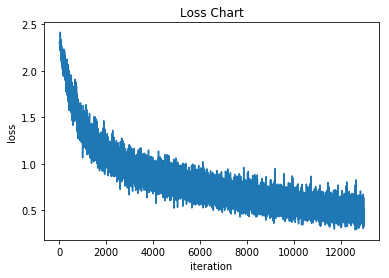

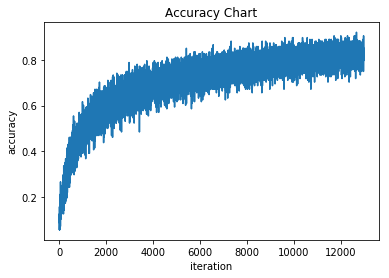

validation for epoch 33
-  epoch 33: validation accuracy = 0.804
train for epoch 34
iteration (13000): loss = 0.473, accuracy = 0.852
iteration (13050): loss = 0.510, accuracy = 0.844
iteration (13100): loss = 0.553, accuracy = 0.781
iteration (13150): loss = 0.454, accuracy = 0.867
iteration (13200): loss = 0.629, accuracy = 0.805
iteration (13250): loss = 0.573, accuracy = 0.766
iteration (13300): loss = 0.494, accuracy = 0.836
iteration (13350): loss = 0.572, accuracy = 0.859


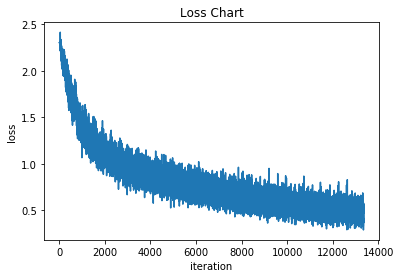

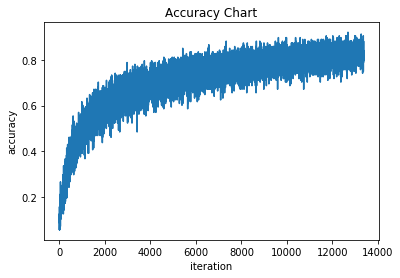

validation for epoch 34
-  epoch 34: validation accuracy = 0.802
train for epoch 35
iteration (13400): loss = 0.490, accuracy = 0.844
iteration (13450): loss = 0.443, accuracy = 0.867
iteration (13500): loss = 0.452, accuracy = 0.820
iteration (13550): loss = 0.522, accuracy = 0.797
iteration (13600): loss = 0.377, accuracy = 0.891
iteration (13650): loss = 0.411, accuracy = 0.852
iteration (13700): loss = 0.364, accuracy = 0.867
iteration (13750): loss = 0.475, accuracy = 0.820


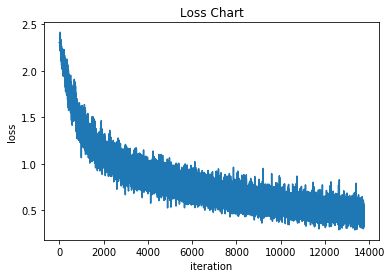

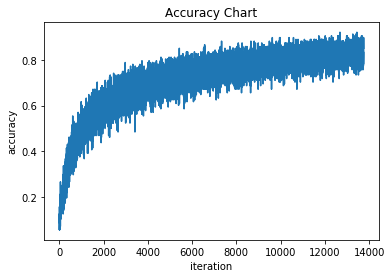

validation for epoch 35
-  epoch 35: validation accuracy = 0.802
train for epoch 36
iteration (13800): loss = 0.468, accuracy = 0.867
iteration (13850): loss = 0.370, accuracy = 0.867
iteration (13900): loss = 0.517, accuracy = 0.789
iteration (13950): loss = 0.395, accuracy = 0.859
iteration (14000): loss = 0.456, accuracy = 0.812
iteration (14050): loss = 0.446, accuracy = 0.820
iteration (14100): loss = 0.446, accuracy = 0.875


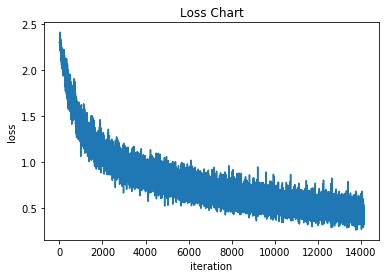

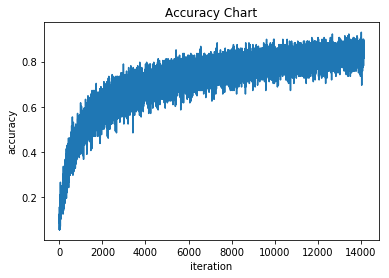

validation for epoch 36
-  epoch 36: validation accuracy = 0.807
train for epoch 37
iteration (14150): loss = 0.344, accuracy = 0.883
iteration (14200): loss = 0.502, accuracy = 0.766
iteration (14250): loss = 0.399, accuracy = 0.836
iteration (14300): loss = 0.494, accuracy = 0.812
iteration (14350): loss = 0.435, accuracy = 0.836
iteration (14400): loss = 0.312, accuracy = 0.906
iteration (14450): loss = 0.494, accuracy = 0.844
iteration (14500): loss = 0.449, accuracy = 0.852


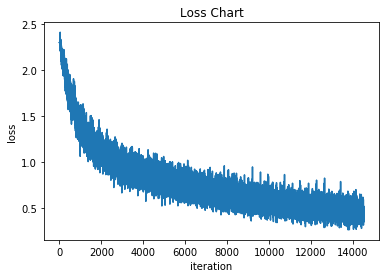

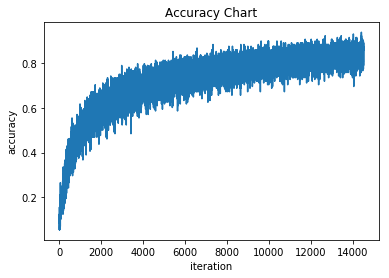

validation for epoch 37
-  epoch 37: validation accuracy = 0.815
train for epoch 38
iteration (14550): loss = 0.388, accuracy = 0.875
iteration (14600): loss = 0.437, accuracy = 0.844
iteration (14650): loss = 0.276, accuracy = 0.891
iteration (14700): loss = 0.420, accuracy = 0.820
iteration (14750): loss = 0.434, accuracy = 0.867
iteration (14800): loss = 0.464, accuracy = 0.844
iteration (14850): loss = 0.368, accuracy = 0.859


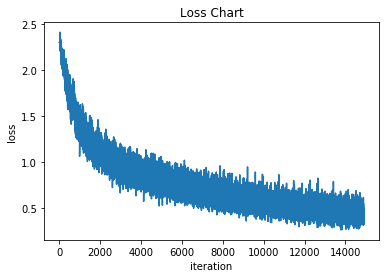

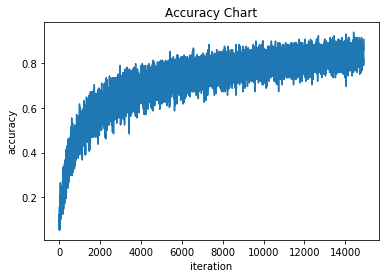

validation for epoch 38
-  epoch 38: validation accuracy = 0.814
train for epoch 39
iteration (14900): loss = 0.501, accuracy = 0.836
iteration (14950): loss = 0.440, accuracy = 0.836
iteration (15000): loss = 0.415, accuracy = 0.836
iteration (15050): loss = 0.438, accuracy = 0.859
iteration (15100): loss = 0.507, accuracy = 0.844
iteration (15150): loss = 0.381, accuracy = 0.883
iteration (15200): loss = 0.385, accuracy = 0.898
iteration (15250): loss = 0.372, accuracy = 0.883


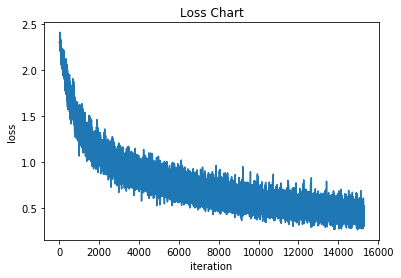

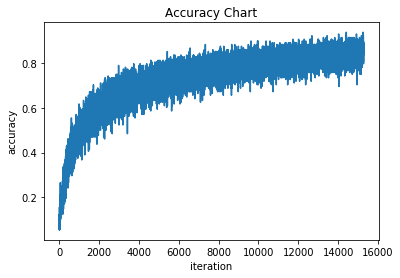

validation for epoch 39
-  epoch 39: validation accuracy = 0.814
train for epoch 40
iteration (15300): loss = 0.249, accuracy = 0.914
iteration (15350): loss = 0.556, accuracy = 0.805
iteration (15400): loss = 0.366, accuracy = 0.875
iteration (15450): loss = 0.373, accuracy = 0.852
iteration (15500): loss = 0.335, accuracy = 0.867
iteration (15550): loss = 0.408, accuracy = 0.859
iteration (15600): loss = 0.466, accuracy = 0.828
iteration (15650): loss = 0.371, accuracy = 0.875


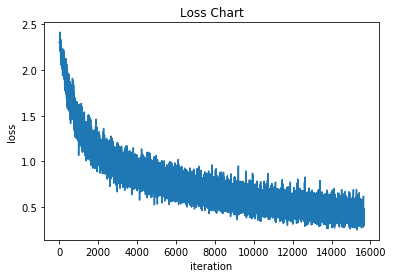

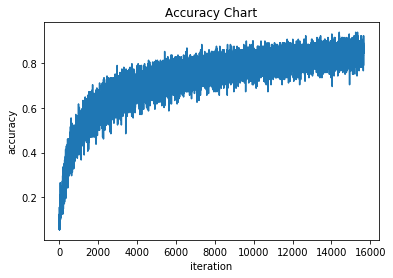

validation for epoch 40
-  epoch 40: validation accuracy = 0.818
train for epoch 41
iteration (15700): loss = 0.622, accuracy = 0.820
iteration (15750): loss = 0.417, accuracy = 0.836
iteration (15800): loss = 0.478, accuracy = 0.836
iteration (15850): loss = 0.438, accuracy = 0.836
iteration (15900): loss = 0.559, accuracy = 0.844
iteration (15950): loss = 0.515, accuracy = 0.812
iteration (16000): loss = 0.514, accuracy = 0.836


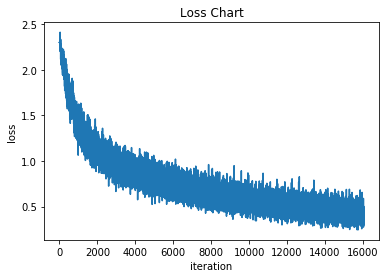

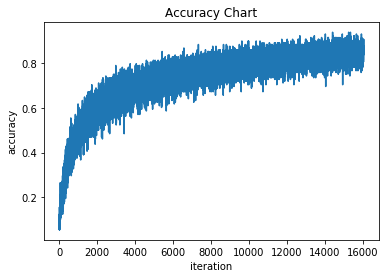

validation for epoch 41
-  epoch 41: validation accuracy = 0.814
train for epoch 42
iteration (16050): loss = 0.374, accuracy = 0.859
iteration (16100): loss = 0.428, accuracy = 0.836
iteration (16150): loss = 0.486, accuracy = 0.859
iteration (16200): loss = 0.444, accuracy = 0.836
iteration (16250): loss = 0.459, accuracy = 0.828
iteration (16300): loss = 0.477, accuracy = 0.805
iteration (16350): loss = 0.362, accuracy = 0.859
iteration (16400): loss = 0.422, accuracy = 0.867


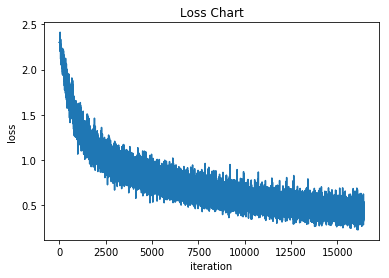

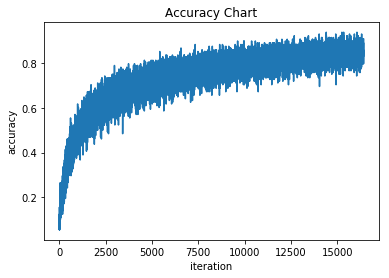

validation for epoch 42
-  epoch 42: validation accuracy = 0.811
train for epoch 43
iteration (16450): loss = 0.477, accuracy = 0.828
iteration (16500): loss = 0.347, accuracy = 0.914
iteration (16550): loss = 0.394, accuracy = 0.844
iteration (16600): loss = 0.405, accuracy = 0.875
iteration (16650): loss = 0.443, accuracy = 0.820
iteration (16700): loss = 0.360, accuracy = 0.867
iteration (16750): loss = 0.498, accuracy = 0.820
iteration (16800): loss = 0.401, accuracy = 0.867


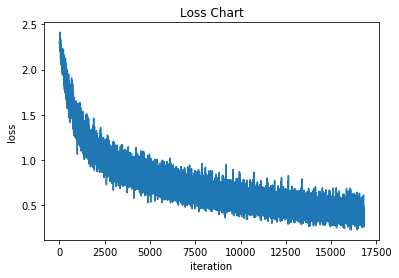

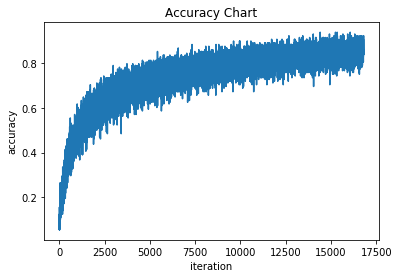

validation for epoch 43
-  epoch 43: validation accuracy = 0.816
train for epoch 44
iteration (16850): loss = 0.544, accuracy = 0.797
iteration (16900): loss = 0.481, accuracy = 0.836
iteration (16950): loss = 0.448, accuracy = 0.852
iteration (17000): loss = 0.377, accuracy = 0.828
iteration (17050): loss = 0.463, accuracy = 0.836
iteration (17100): loss = 0.400, accuracy = 0.852
iteration (17150): loss = 0.415, accuracy = 0.867


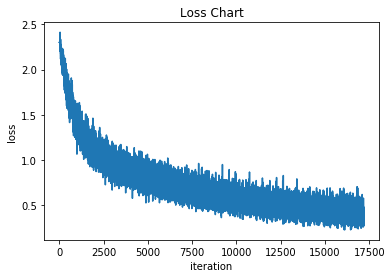

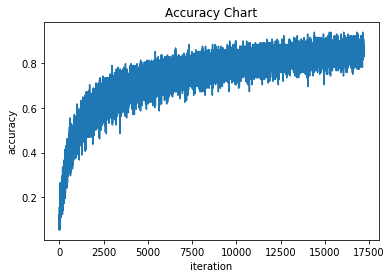

validation for epoch 44
-  epoch 44: validation accuracy = 0.815
train for epoch 45
iteration (17200): loss = 0.501, accuracy = 0.859
iteration (17250): loss = 0.322, accuracy = 0.875
iteration (17300): loss = 0.446, accuracy = 0.828
iteration (17350): loss = 0.439, accuracy = 0.852
iteration (17400): loss = 0.480, accuracy = 0.836
iteration (17450): loss = 0.504, accuracy = 0.836
iteration (17500): loss = 0.592, accuracy = 0.773
iteration (17550): loss = 0.310, accuracy = 0.906


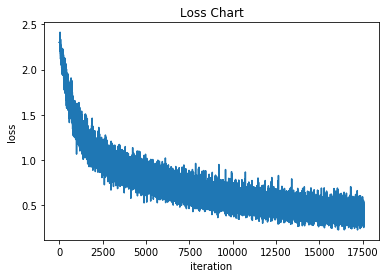

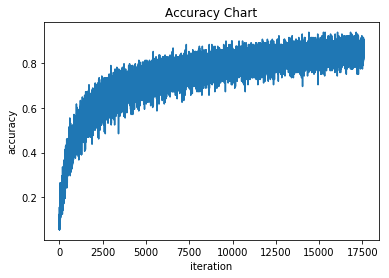

validation for epoch 45
-  epoch 45: validation accuracy = 0.815
train for epoch 46
iteration (17600): loss = 0.330, accuracy = 0.898
iteration (17650): loss = 0.316, accuracy = 0.906
iteration (17700): loss = 0.476, accuracy = 0.859
iteration (17750): loss = 0.433, accuracy = 0.859
iteration (17800): loss = 0.366, accuracy = 0.867
iteration (17850): loss = 0.270, accuracy = 0.922
iteration (17900): loss = 0.401, accuracy = 0.852
iteration (17950): loss = 0.258, accuracy = 0.922


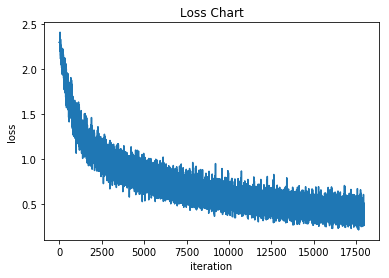

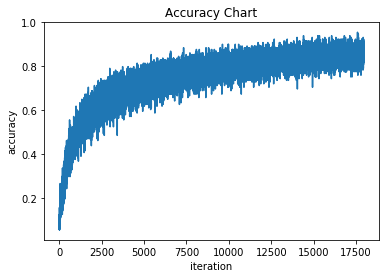

validation for epoch 46
-  epoch 46: validation accuracy = 0.814
train for epoch 47
iteration (18000): loss = 0.328, accuracy = 0.898
iteration (18050): loss = 0.447, accuracy = 0.820
iteration (18100): loss = 0.375, accuracy = 0.836
iteration (18150): loss = 0.402, accuracy = 0.805
iteration (18200): loss = 0.349, accuracy = 0.883
iteration (18250): loss = 0.384, accuracy = 0.859
iteration (18300): loss = 0.342, accuracy = 0.859


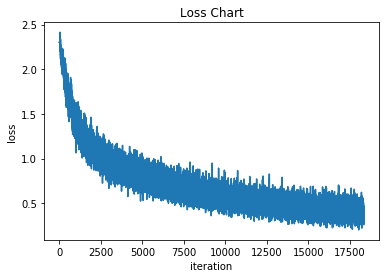

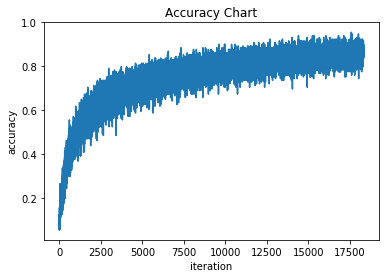

validation for epoch 47
-  epoch 47: validation accuracy = 0.826
train for epoch 48
iteration (18350): loss = 0.373, accuracy = 0.859
iteration (18400): loss = 0.501, accuracy = 0.828
iteration (18450): loss = 0.384, accuracy = 0.875
iteration (18500): loss = 0.475, accuracy = 0.836
iteration (18550): loss = 0.348, accuracy = 0.859
iteration (18600): loss = 0.383, accuracy = 0.844
iteration (18650): loss = 0.293, accuracy = 0.906
iteration (18700): loss = 0.432, accuracy = 0.852


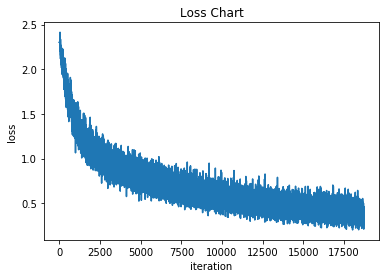

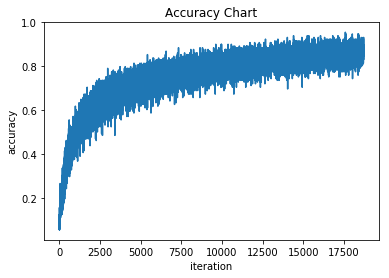

validation for epoch 48
-  epoch 48: validation accuracy = 0.810
train for epoch 49
iteration (18750): loss = 0.505, accuracy = 0.844
iteration (18800): loss = 0.259, accuracy = 0.914
iteration (18850): loss = 0.351, accuracy = 0.852
iteration (18900): loss = 0.358, accuracy = 0.891
iteration (18950): loss = 0.316, accuracy = 0.898
iteration (19000): loss = 0.419, accuracy = 0.836
iteration (19050): loss = 0.428, accuracy = 0.828


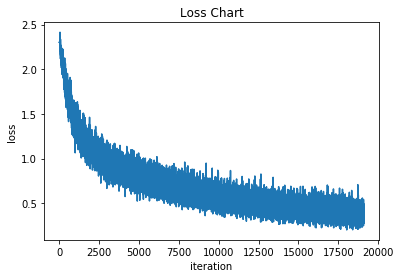

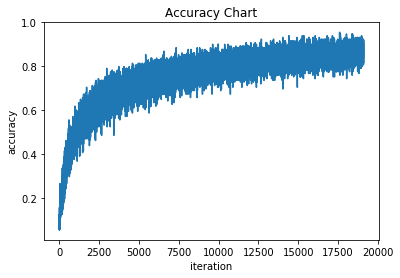

validation for epoch 49
-  epoch 49: validation accuracy = 0.811
train for epoch 50
iteration (19100): loss = 0.300, accuracy = 0.914
iteration (19150): loss = 0.354, accuracy = 0.883
iteration (19200): loss = 0.358, accuracy = 0.875
iteration (19250): loss = 0.403, accuracy = 0.875
iteration (19300): loss = 0.373, accuracy = 0.859
iteration (19350): loss = 0.504, accuracy = 0.820
iteration (19400): loss = 0.366, accuracy = 0.875
iteration (19450): loss = 0.385, accuracy = 0.828


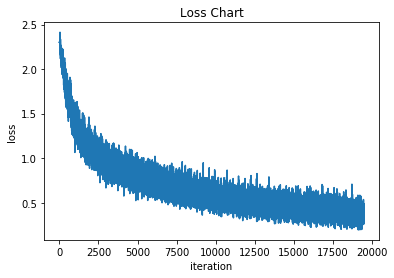

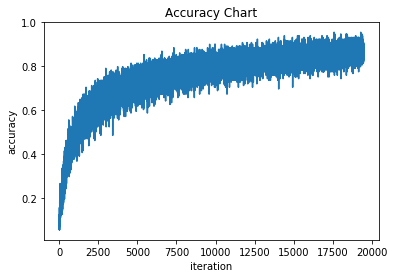

validation for epoch 50
-  epoch 50: validation accuracy = 0.812
train for epoch 51
iteration (19500): loss = 0.356, accuracy = 0.867
iteration (19550): loss = 0.390, accuracy = 0.875
iteration (19600): loss = 0.368, accuracy = 0.820
iteration (19650): loss = 0.367, accuracy = 0.867
iteration (19700): loss = 0.309, accuracy = 0.898
iteration (19750): loss = 0.446, accuracy = 0.859
iteration (19800): loss = 0.345, accuracy = 0.906
iteration (19850): loss = 0.271, accuracy = 0.898


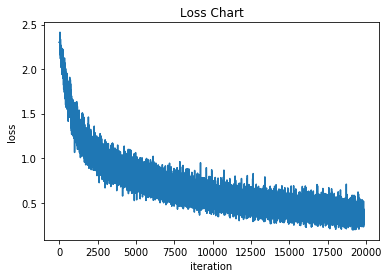

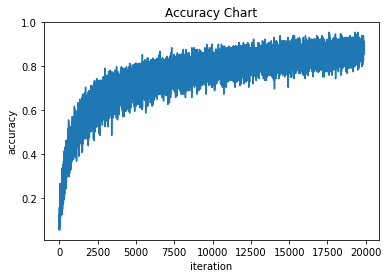

validation for epoch 51
-  epoch 51: validation accuracy = 0.818
train for epoch 52
iteration (19900): loss = 0.377, accuracy = 0.898
iteration (19950): loss = 0.367, accuracy = 0.875
iteration (20000): loss = 0.404, accuracy = 0.867
iteration (20050): loss = 0.315, accuracy = 0.898
iteration (20100): loss = 0.340, accuracy = 0.859
iteration (20150): loss = 0.358, accuracy = 0.859
iteration (20200): loss = 0.386, accuracy = 0.883


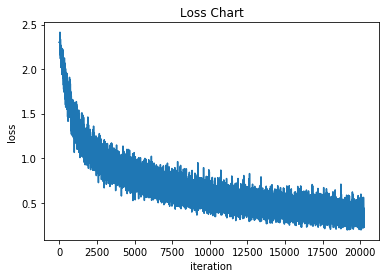

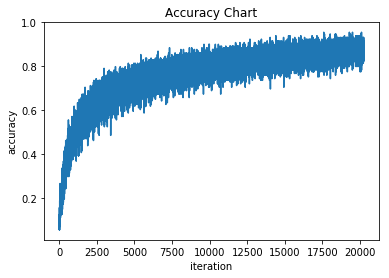

validation for epoch 52
-  epoch 52: validation accuracy = 0.818
train for epoch 53
iteration (20250): loss = 0.312, accuracy = 0.867
iteration (20300): loss = 0.244, accuracy = 0.898
iteration (20350): loss = 0.362, accuracy = 0.875
iteration (20400): loss = 0.467, accuracy = 0.805
iteration (20450): loss = 0.300, accuracy = 0.898
iteration (20500): loss = 0.355, accuracy = 0.875
iteration (20550): loss = 0.421, accuracy = 0.852
iteration (20600): loss = 0.270, accuracy = 0.906


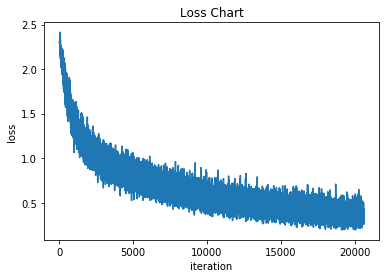

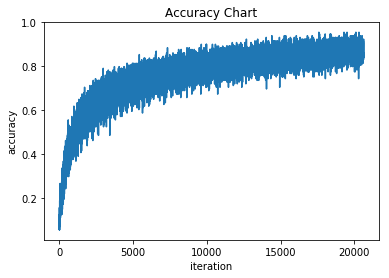

validation for epoch 53
-  epoch 53: validation accuracy = 0.816
train for epoch 54
iteration (20650): loss = 0.347, accuracy = 0.906
iteration (20700): loss = 0.430, accuracy = 0.867
iteration (20750): loss = 0.479, accuracy = 0.867
iteration (20800): loss = 0.224, accuracy = 0.922
iteration (20850): loss = 0.464, accuracy = 0.852
iteration (20900): loss = 0.270, accuracy = 0.930
iteration (20950): loss = 0.346, accuracy = 0.875
iteration (21000): loss = 0.382, accuracy = 0.852


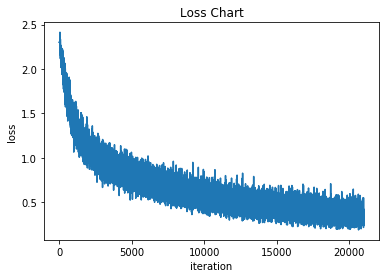

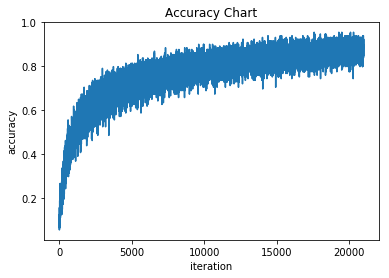

validation for epoch 54
-  epoch 54: validation accuracy = 0.817
train for epoch 55
iteration (21050): loss = 0.391, accuracy = 0.844
iteration (21100): loss = 0.328, accuracy = 0.914
iteration (21150): loss = 0.362, accuracy = 0.859
iteration (21200): loss = 0.559, accuracy = 0.812
iteration (21250): loss = 0.469, accuracy = 0.828
iteration (21300): loss = 0.351, accuracy = 0.859
iteration (21350): loss = 0.311, accuracy = 0.883


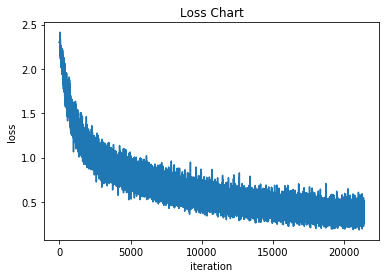

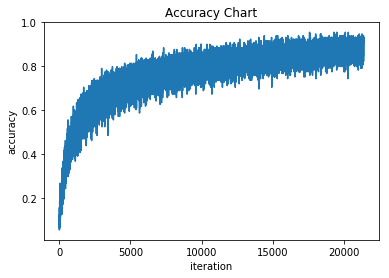

validation for epoch 55
-  epoch 55: validation accuracy = 0.816
train for epoch 56
iteration (21400): loss = 0.352, accuracy = 0.906
iteration (21450): loss = 0.275, accuracy = 0.891
iteration (21500): loss = 0.444, accuracy = 0.891
iteration (21550): loss = 0.403, accuracy = 0.859
iteration (21600): loss = 0.394, accuracy = 0.867
iteration (21650): loss = 0.364, accuracy = 0.859
iteration (21700): loss = 0.299, accuracy = 0.898
iteration (21750): loss = 0.392, accuracy = 0.852


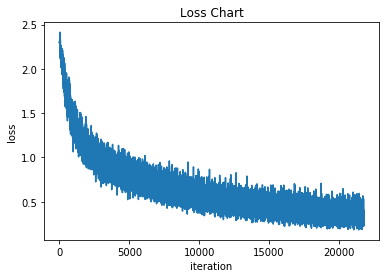

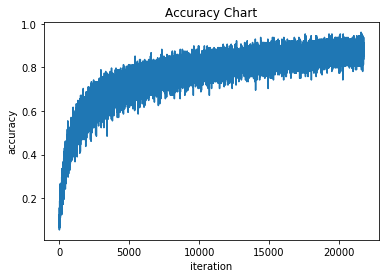

validation for epoch 56
-  epoch 56: validation accuracy = 0.817
train for epoch 57
iteration (21800): loss = 0.542, accuracy = 0.820
iteration (21850): loss = 0.413, accuracy = 0.867
iteration (21900): loss = 0.299, accuracy = 0.891
iteration (21950): loss = 0.336, accuracy = 0.875
iteration (22000): loss = 0.362, accuracy = 0.852
iteration (22050): loss = 0.353, accuracy = 0.867
iteration (22100): loss = 0.335, accuracy = 0.891
iteration (22150): loss = 0.311, accuracy = 0.891


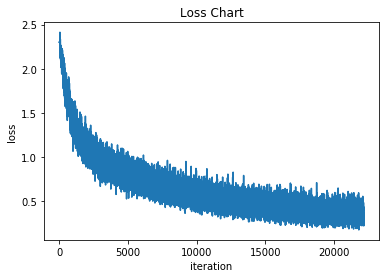

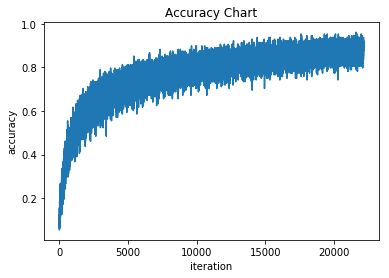

validation for epoch 57
-  epoch 57: validation accuracy = 0.829
train for epoch 58
iteration (22200): loss = 0.411, accuracy = 0.867
iteration (22250): loss = 0.330, accuracy = 0.898
iteration (22300): loss = 0.390, accuracy = 0.844
iteration (22350): loss = 0.340, accuracy = 0.883
iteration (22400): loss = 0.325, accuracy = 0.898
iteration (22450): loss = 0.419, accuracy = 0.852
iteration (22500): loss = 0.278, accuracy = 0.914


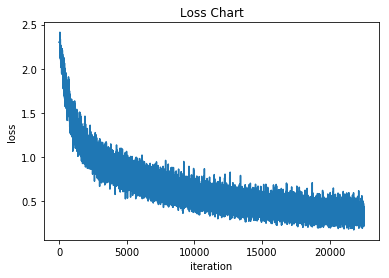

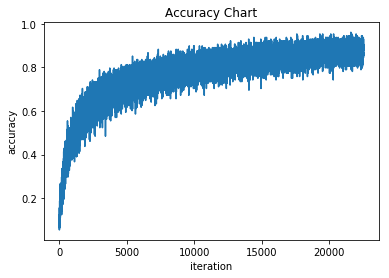

validation for epoch 58
-  epoch 58: validation accuracy = 0.821
train for epoch 59
iteration (22550): loss = 0.363, accuracy = 0.891
iteration (22600): loss = 0.420, accuracy = 0.867
iteration (22650): loss = 0.365, accuracy = 0.844
iteration (22700): loss = 0.361, accuracy = 0.898
iteration (22750): loss = 0.432, accuracy = 0.852
iteration (22800): loss = 0.495, accuracy = 0.805
iteration (22850): loss = 0.391, accuracy = 0.852
iteration (22900): loss = 0.345, accuracy = 0.883


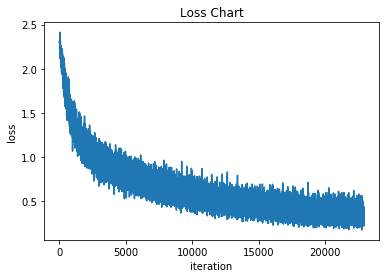

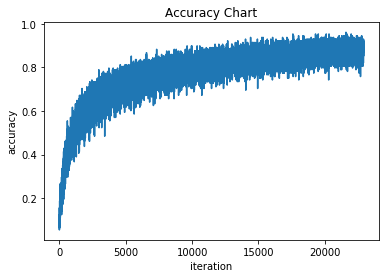

validation for epoch 59
-  epoch 59: validation accuracy = 0.819
train for epoch 60
iteration (22950): loss = 0.327, accuracy = 0.891
iteration (23000): loss = 0.261, accuracy = 0.922
iteration (23050): loss = 0.385, accuracy = 0.891
iteration (23100): loss = 0.399, accuracy = 0.859
iteration (23150): loss = 0.341, accuracy = 0.859
iteration (23200): loss = 0.309, accuracy = 0.875
iteration (23250): loss = 0.306, accuracy = 0.883
iteration (23300): loss = 0.294, accuracy = 0.883


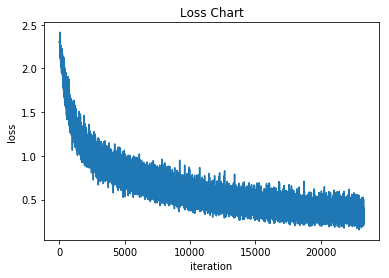

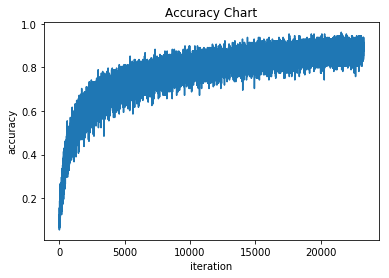

validation for epoch 60
-  epoch 60: validation accuracy = 0.812
train for epoch 61
iteration (23350): loss = 0.301, accuracy = 0.891
iteration (23400): loss = 0.269, accuracy = 0.906
iteration (23450): loss = 0.346, accuracy = 0.883
iteration (23500): loss = 0.334, accuracy = 0.898
iteration (23550): loss = 0.351, accuracy = 0.852
iteration (23600): loss = 0.292, accuracy = 0.883
iteration (23650): loss = 0.401, accuracy = 0.875


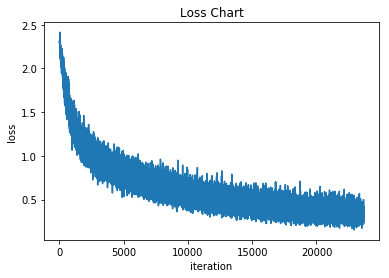

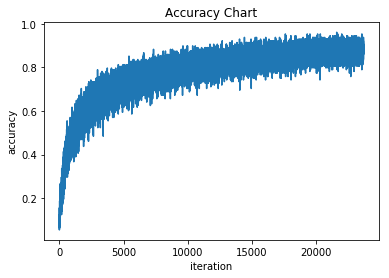

validation for epoch 61
-  epoch 61: validation accuracy = 0.818
train for epoch 62
iteration (23700): loss = 0.310, accuracy = 0.891
iteration (23750): loss = 0.366, accuracy = 0.891
iteration (23800): loss = 0.311, accuracy = 0.891
iteration (23850): loss = 0.453, accuracy = 0.852
iteration (23900): loss = 0.260, accuracy = 0.883
iteration (23950): loss = 0.202, accuracy = 0.914
iteration (24000): loss = 0.390, accuracy = 0.875
iteration (24050): loss = 0.331, accuracy = 0.891


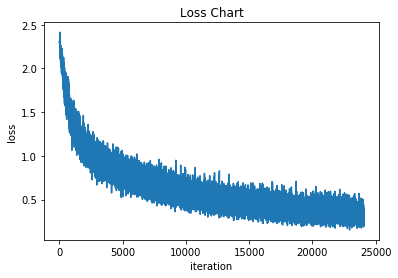

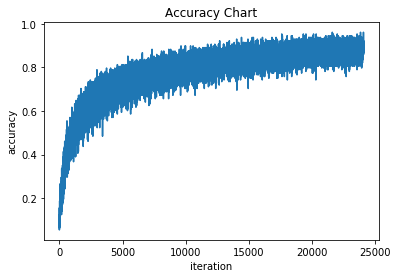

validation for epoch 62
-  epoch 62: validation accuracy = 0.817
train for epoch 63
iteration (24100): loss = 0.284, accuracy = 0.898
iteration (24150): loss = 0.246, accuracy = 0.945
iteration (24200): loss = 0.261, accuracy = 0.875
iteration (24250): loss = 0.314, accuracy = 0.891
iteration (24300): loss = 0.370, accuracy = 0.891
iteration (24350): loss = 0.333, accuracy = 0.836
iteration (24400): loss = 0.372, accuracy = 0.898


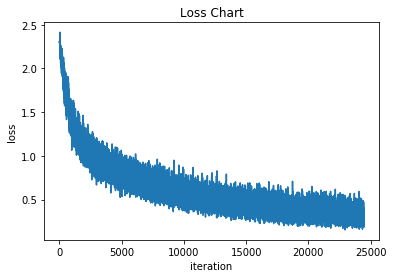

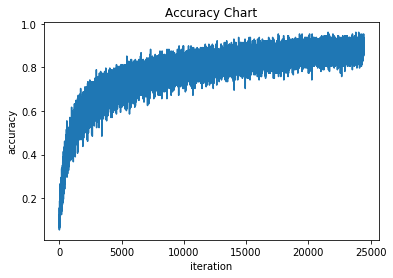

validation for epoch 63
-  epoch 63: validation accuracy = 0.816
train for epoch 64
iteration (24450): loss = 0.377, accuracy = 0.859
iteration (24500): loss = 0.262, accuracy = 0.906
iteration (24550): loss = 0.305, accuracy = 0.906
iteration (24600): loss = 0.404, accuracy = 0.891
iteration (24650): loss = 0.333, accuracy = 0.883
iteration (24700): loss = 0.290, accuracy = 0.938
iteration (24750): loss = 0.257, accuracy = 0.922
iteration (24800): loss = 0.261, accuracy = 0.906


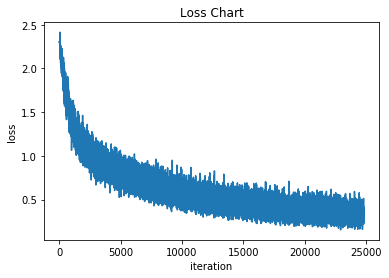

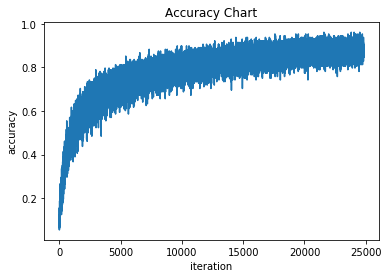

validation for epoch 64
-  epoch 64: validation accuracy = 0.812
train for epoch 65
iteration (24850): loss = 0.180, accuracy = 0.914
iteration (24900): loss = 0.446, accuracy = 0.836
iteration (24950): loss = 0.300, accuracy = 0.906
iteration (25000): loss = 0.295, accuracy = 0.875
iteration (25050): loss = 0.306, accuracy = 0.898
iteration (25100): loss = 0.313, accuracy = 0.898
iteration (25150): loss = 0.322, accuracy = 0.898
iteration (25200): loss = 0.311, accuracy = 0.891


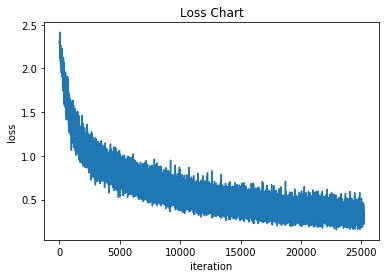

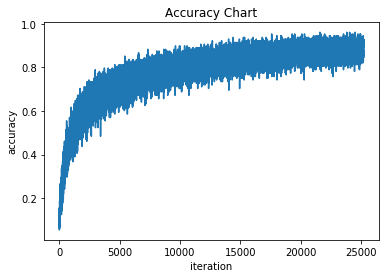

validation for epoch 65
-  epoch 65: validation accuracy = 0.817
train for epoch 66
iteration (25250): loss = 0.441, accuracy = 0.883
iteration (25300): loss = 0.289, accuracy = 0.906
iteration (25350): loss = 0.420, accuracy = 0.859
iteration (25400): loss = 0.289, accuracy = 0.914
iteration (25450): loss = 0.384, accuracy = 0.844
iteration (25500): loss = 0.361, accuracy = 0.867
iteration (25550): loss = 0.326, accuracy = 0.883


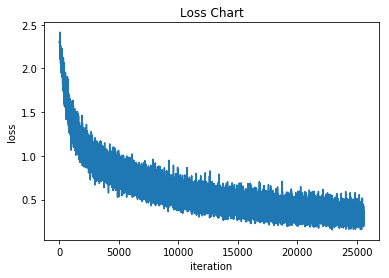

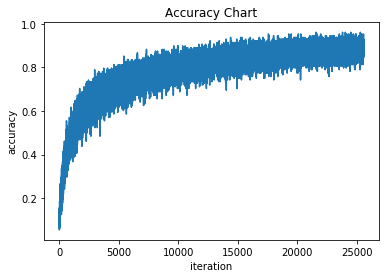

validation for epoch 66
-  epoch 66: validation accuracy = 0.823
train for epoch 67
iteration (25600): loss = 0.298, accuracy = 0.906
iteration (25650): loss = 0.242, accuracy = 0.922
iteration (25700): loss = 0.369, accuracy = 0.859
iteration (25750): loss = 0.407, accuracy = 0.883
iteration (25800): loss = 0.312, accuracy = 0.875
iteration (25850): loss = 0.371, accuracy = 0.859
iteration (25900): loss = 0.314, accuracy = 0.891
iteration (25950): loss = 0.251, accuracy = 0.914


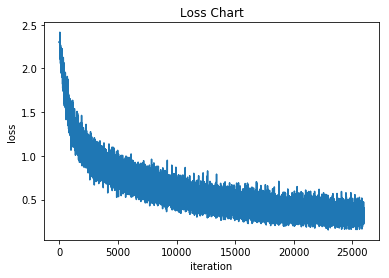

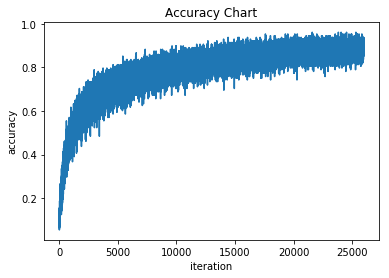

validation for epoch 67
-  epoch 67: validation accuracy = 0.815
train for epoch 68
iteration (26000): loss = 0.369, accuracy = 0.875
iteration (26050): loss = 0.258, accuracy = 0.906
iteration (26100): loss = 0.269, accuracy = 0.906
iteration (26150): loss = 0.318, accuracy = 0.906
iteration (26200): loss = 0.301, accuracy = 0.875
iteration (26250): loss = 0.272, accuracy = 0.906
iteration (26300): loss = 0.389, accuracy = 0.859
iteration (26350): loss = 0.445, accuracy = 0.812


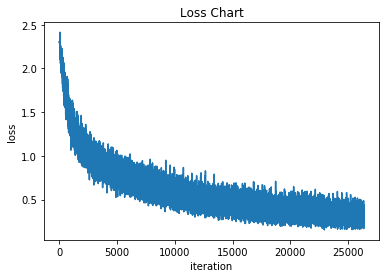

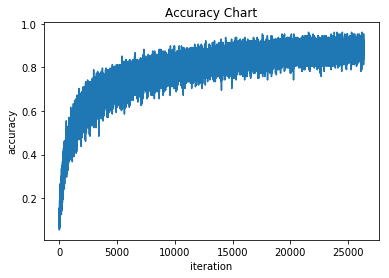

validation for epoch 68
-  epoch 68: validation accuracy = 0.812
train for epoch 69
iteration (26400): loss = 0.387, accuracy = 0.883
iteration (26450): loss = 0.436, accuracy = 0.820
iteration (26500): loss = 0.441, accuracy = 0.820
iteration (26550): loss = 0.304, accuracy = 0.867
iteration (26600): loss = 0.341, accuracy = 0.875
iteration (26650): loss = 0.329, accuracy = 0.859
iteration (26700): loss = 0.229, accuracy = 0.930


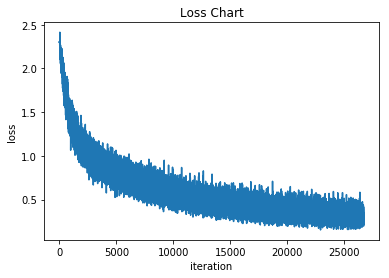

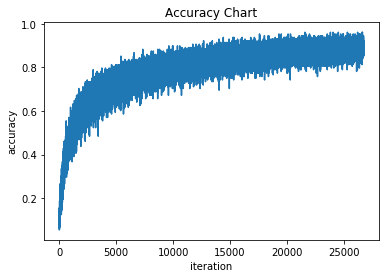

validation for epoch 69
-  epoch 69: validation accuracy = 0.815
train for epoch 70
iteration (26750): loss = 0.389, accuracy = 0.859
iteration (26800): loss = 0.214, accuracy = 0.914
iteration (26850): loss = 0.323, accuracy = 0.898
iteration (26900): loss = 0.367, accuracy = 0.883
iteration (26950): loss = 0.377, accuracy = 0.891
iteration (27000): loss = 0.325, accuracy = 0.898
iteration (27050): loss = 0.333, accuracy = 0.867
iteration (27100): loss = 0.230, accuracy = 0.898


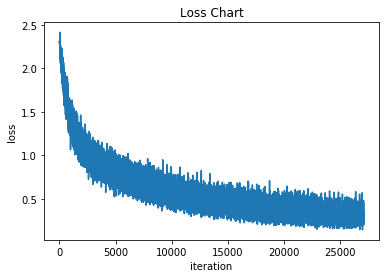

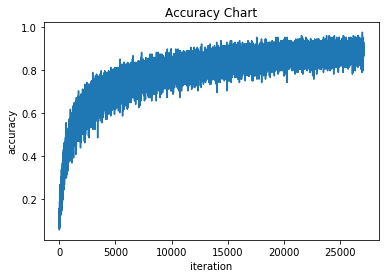

validation for epoch 70
-  epoch 70: validation accuracy = 0.819
train for epoch 71
iteration (27150): loss = 0.290, accuracy = 0.914
iteration (27200): loss = 0.331, accuracy = 0.867
iteration (27250): loss = 0.367, accuracy = 0.867
iteration (27300): loss = 0.286, accuracy = 0.891
iteration (27350): loss = 0.207, accuracy = 0.938
iteration (27400): loss = 0.170, accuracy = 0.938
iteration (27450): loss = 0.377, accuracy = 0.891
iteration (27500): loss = 0.199, accuracy = 0.945


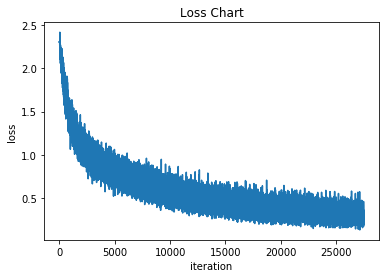

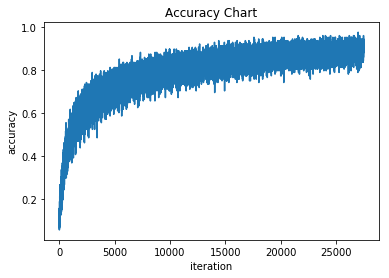

validation for epoch 71
-  epoch 71: validation accuracy = 0.820
train for epoch 72
iteration (27550): loss = 0.312, accuracy = 0.914
iteration (27600): loss = 0.349, accuracy = 0.875
iteration (27650): loss = 0.244, accuracy = 0.891
iteration (27700): loss = 0.308, accuracy = 0.883
iteration (27750): loss = 0.332, accuracy = 0.922
iteration (27800): loss = 0.262, accuracy = 0.906
iteration (27850): loss = 0.319, accuracy = 0.891


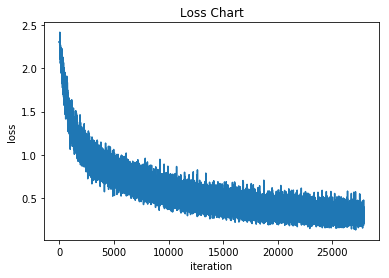

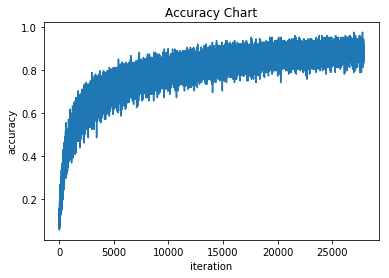

validation for epoch 72
-  epoch 72: validation accuracy = 0.825
train for epoch 73
iteration (27900): loss = 0.290, accuracy = 0.867
iteration (27950): loss = 0.345, accuracy = 0.891
iteration (28000): loss = 0.226, accuracy = 0.906
iteration (28050): loss = 0.378, accuracy = 0.859
iteration (28100): loss = 0.191, accuracy = 0.938
iteration (28150): loss = 0.313, accuracy = 0.898
iteration (28200): loss = 0.238, accuracy = 0.914
iteration (28250): loss = 0.236, accuracy = 0.922


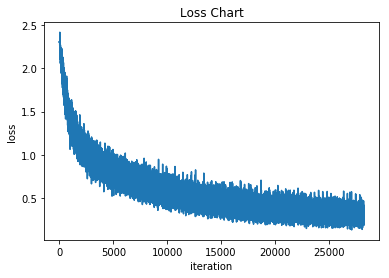

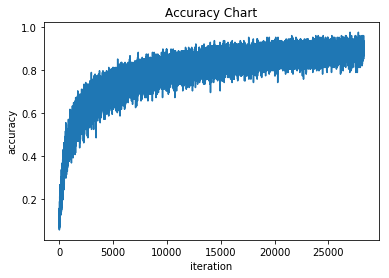

validation for epoch 73
-  epoch 73: validation accuracy = 0.815
train for epoch 74
iteration (28300): loss = 0.364, accuracy = 0.867
iteration (28350): loss = 0.245, accuracy = 0.914
iteration (28400): loss = 0.279, accuracy = 0.906
iteration (28450): loss = 0.328, accuracy = 0.875
iteration (28500): loss = 0.250, accuracy = 0.914
iteration (28550): loss = 0.297, accuracy = 0.906
iteration (28600): loss = 0.350, accuracy = 0.875


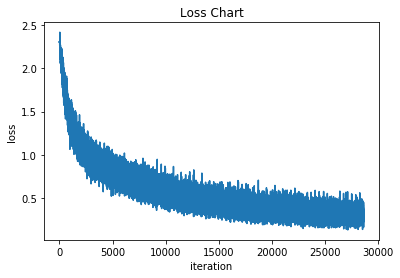

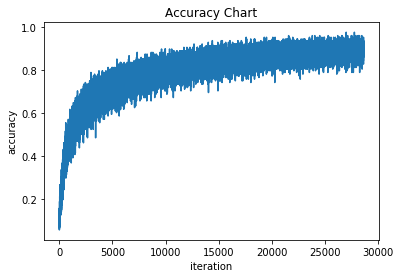

validation for epoch 74
-  epoch 74: validation accuracy = 0.820
train for epoch 75
iteration (28650): loss = 0.256, accuracy = 0.930
iteration (28700): loss = 0.294, accuracy = 0.867
iteration (28750): loss = 0.235, accuracy = 0.914
iteration (28800): loss = 0.437, accuracy = 0.852
iteration (28850): loss = 0.361, accuracy = 0.852
iteration (28900): loss = 0.245, accuracy = 0.906
iteration (28950): loss = 0.327, accuracy = 0.867
iteration (29000): loss = 0.294, accuracy = 0.906


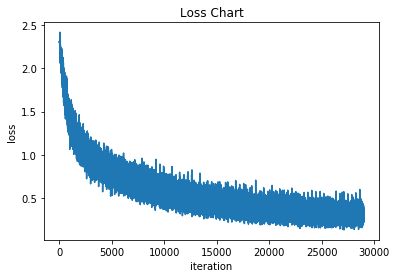

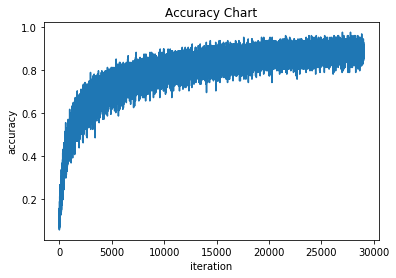

validation for epoch 75
-  epoch 75: validation accuracy = 0.824
train for epoch 76
iteration (29050): loss = 0.299, accuracy = 0.867
iteration (29100): loss = 0.248, accuracy = 0.898
iteration (29150): loss = 0.322, accuracy = 0.883
iteration (29200): loss = 0.307, accuracy = 0.898
iteration (29250): loss = 0.182, accuracy = 0.922
iteration (29300): loss = 0.264, accuracy = 0.906
iteration (29350): loss = 0.269, accuracy = 0.922
iteration (29400): loss = 0.249, accuracy = 0.930


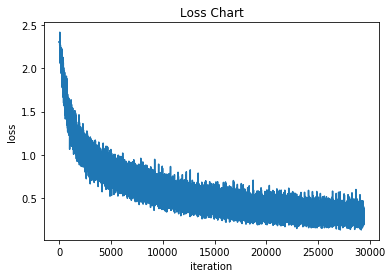

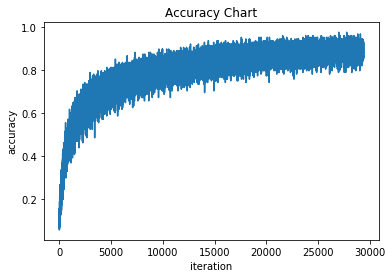

validation for epoch 76
-  epoch 76: validation accuracy = 0.818
train for epoch 77
iteration (29450): loss = 0.277, accuracy = 0.914
iteration (29500): loss = 0.319, accuracy = 0.891
iteration (29550): loss = 0.272, accuracy = 0.906
iteration (29600): loss = 0.226, accuracy = 0.930
iteration (29650): loss = 0.311, accuracy = 0.891
iteration (29700): loss = 0.245, accuracy = 0.930
iteration (29750): loss = 0.339, accuracy = 0.898


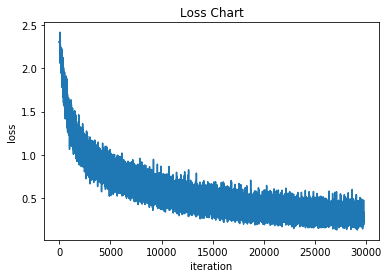

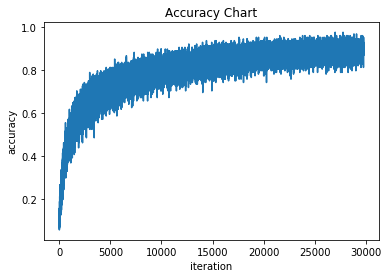

validation for epoch 77
-  epoch 77: validation accuracy = 0.825
train for epoch 78
iteration (29800): loss = 0.315, accuracy = 0.891
iteration (29850): loss = 0.132, accuracy = 0.969
iteration (29900): loss = 0.270, accuracy = 0.898
iteration (29950): loss = 0.315, accuracy = 0.891
iteration (30000): loss = 0.194, accuracy = 0.922
iteration (30050): loss = 0.348, accuracy = 0.859
iteration (30100): loss = 0.320, accuracy = 0.906
iteration (30150): loss = 0.220, accuracy = 0.898


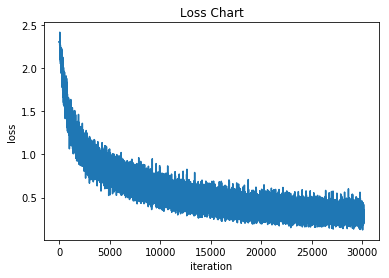

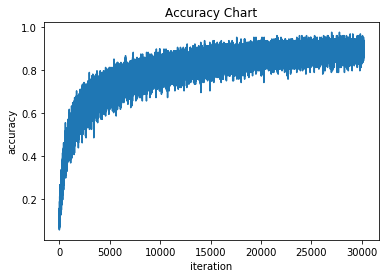

validation for epoch 78
-  epoch 78: validation accuracy = 0.817
train for epoch 79
iteration (30200): loss = 0.190, accuracy = 0.930
iteration (30250): loss = 0.338, accuracy = 0.898
iteration (30300): loss = 0.449, accuracy = 0.844
iteration (30350): loss = 0.226, accuracy = 0.930
iteration (30400): loss = 0.367, accuracy = 0.859
iteration (30450): loss = 0.177, accuracy = 0.938
iteration (30500): loss = 0.260, accuracy = 0.930
iteration (30550): loss = 0.324, accuracy = 0.883


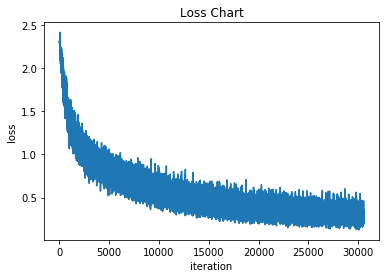

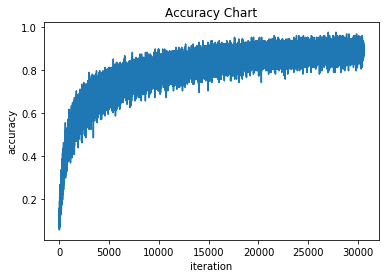

validation for epoch 79
-  epoch 79: validation accuracy = 0.824
train for epoch 80
iteration (30600): loss = 0.296, accuracy = 0.898
iteration (30650): loss = 0.286, accuracy = 0.898
iteration (30700): loss = 0.296, accuracy = 0.883
iteration (30750): loss = 0.408, accuracy = 0.867
iteration (30800): loss = 0.368, accuracy = 0.867
iteration (30850): loss = 0.284, accuracy = 0.898
iteration (30900): loss = 0.232, accuracy = 0.906


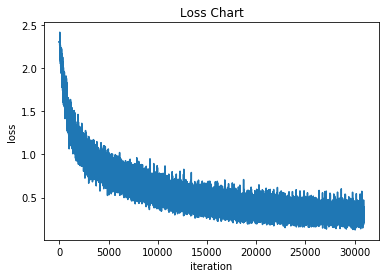

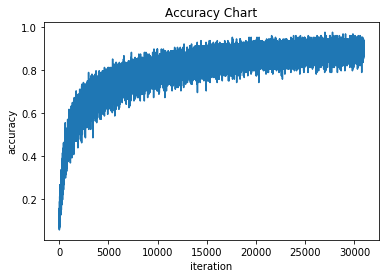

validation for epoch 80
-  epoch 80: validation accuracy = 0.823
train for epoch 81
iteration (30950): loss = 0.281, accuracy = 0.906
iteration (31000): loss = 0.254, accuracy = 0.914
iteration (31050): loss = 0.291, accuracy = 0.914
iteration (31100): loss = 0.246, accuracy = 0.930
iteration (31150): loss = 0.289, accuracy = 0.875
iteration (31200): loss = 0.379, accuracy = 0.859
iteration (31250): loss = 0.263, accuracy = 0.898
iteration (31300): loss = 0.323, accuracy = 0.859


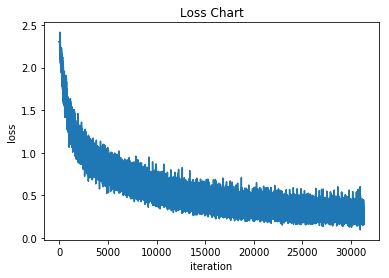

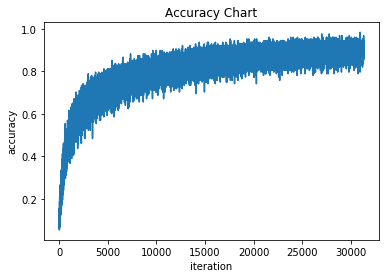

validation for epoch 81
-  epoch 81: validation accuracy = 0.820
train for epoch 82
iteration (31350): loss = 0.304, accuracy = 0.906
iteration (31400): loss = 0.390, accuracy = 0.883
iteration (31450): loss = 0.243, accuracy = 0.914
iteration (31500): loss = 0.207, accuracy = 0.945
iteration (31550): loss = 0.222, accuracy = 0.930
iteration (31600): loss = 0.257, accuracy = 0.906
iteration (31650): loss = 0.268, accuracy = 0.883
iteration (31700): loss = 0.236, accuracy = 0.922


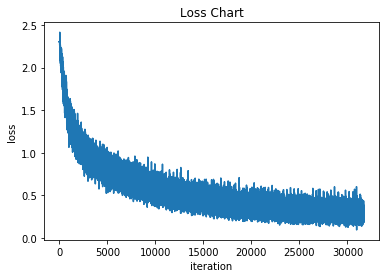

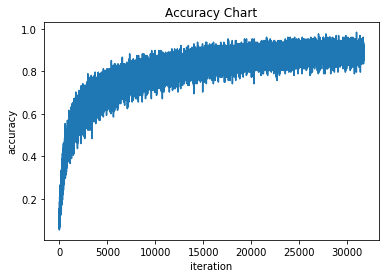

validation for epoch 82
-  epoch 82: validation accuracy = 0.823
train for epoch 83
iteration (31750): loss = 0.344, accuracy = 0.875
iteration (31800): loss = 0.285, accuracy = 0.930
iteration (31850): loss = 0.322, accuracy = 0.852
iteration (31900): loss = 0.337, accuracy = 0.883
iteration (31950): loss = 0.226, accuracy = 0.945
iteration (32000): loss = 0.265, accuracy = 0.914
iteration (32050): loss = 0.279, accuracy = 0.891


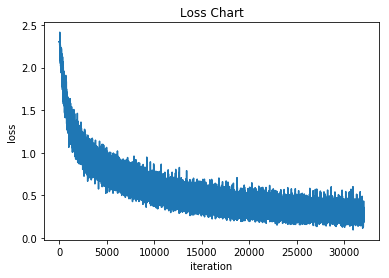

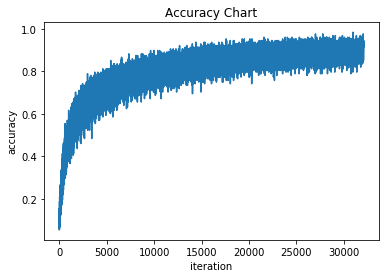

validation for epoch 83
-  epoch 83: validation accuracy = 0.818
train for epoch 84
iteration (32100): loss = 0.363, accuracy = 0.891
iteration (32150): loss = 0.428, accuracy = 0.875
iteration (32200): loss = 0.349, accuracy = 0.852
iteration (32250): loss = 0.349, accuracy = 0.891
iteration (32300): loss = 0.345, accuracy = 0.891
iteration (32350): loss = 0.398, accuracy = 0.859
iteration (32400): loss = 0.354, accuracy = 0.875
iteration (32450): loss = 0.276, accuracy = 0.906


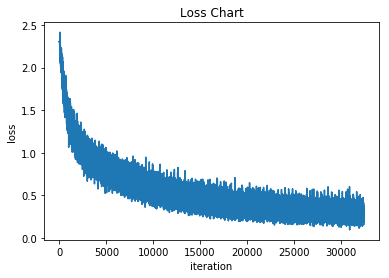

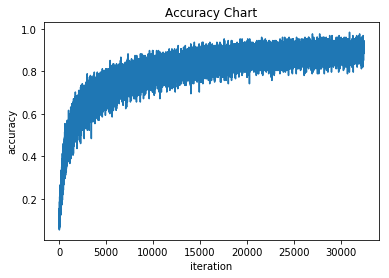

validation for epoch 84
-  epoch 84: validation accuracy = 0.824
train for epoch 85
iteration (32500): loss = 0.310, accuracy = 0.875
iteration (32550): loss = 0.196, accuracy = 0.953
iteration (32600): loss = 0.345, accuracy = 0.883
iteration (32650): loss = 0.361, accuracy = 0.875
iteration (32700): loss = 0.231, accuracy = 0.930
iteration (32750): loss = 0.209, accuracy = 0.922
iteration (32800): loss = 0.218, accuracy = 0.922
iteration (32850): loss = 0.287, accuracy = 0.906


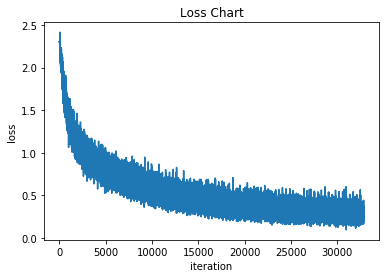

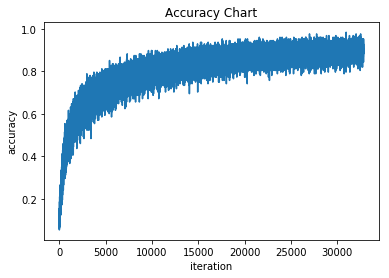

validation for epoch 85
-  epoch 85: validation accuracy = 0.826
train for epoch 86
iteration (32900): loss = 0.272, accuracy = 0.906
iteration (32950): loss = 0.267, accuracy = 0.883
iteration (33000): loss = 0.292, accuracy = 0.891
iteration (33050): loss = 0.201, accuracy = 0.953
iteration (33100): loss = 0.209, accuracy = 0.914
iteration (33150): loss = 0.253, accuracy = 0.922
iteration (33200): loss = 0.212, accuracy = 0.938


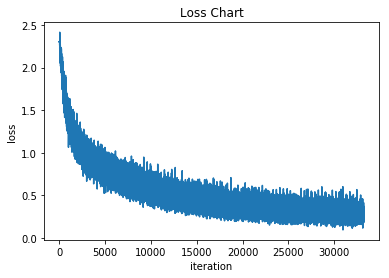

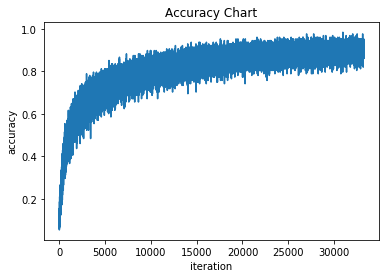

validation for epoch 86
-  epoch 86: validation accuracy = 0.826
train for epoch 87
iteration (33250): loss = 0.285, accuracy = 0.898
iteration (33300): loss = 0.311, accuracy = 0.883
iteration (33350): loss = 0.324, accuracy = 0.914
iteration (33400): loss = 0.341, accuracy = 0.891
iteration (33450): loss = 0.181, accuracy = 0.961
iteration (33500): loss = 0.178, accuracy = 0.930
iteration (33550): loss = 0.348, accuracy = 0.867
iteration (33600): loss = 0.227, accuracy = 0.938


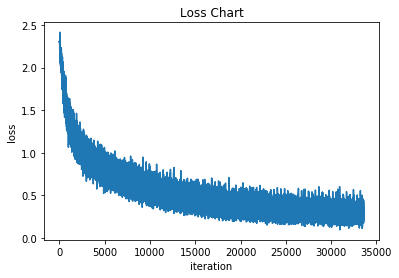

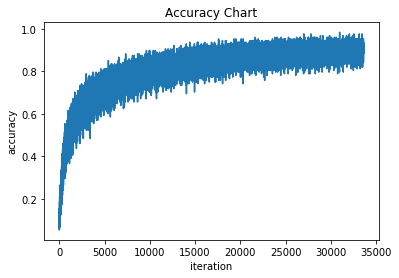

validation for epoch 87
-  epoch 87: validation accuracy = 0.830
train for epoch 88
iteration (33650): loss = 0.234, accuracy = 0.891
iteration (33700): loss = 0.242, accuracy = 0.914
iteration (33750): loss = 0.140, accuracy = 0.953
iteration (33800): loss = 0.273, accuracy = 0.898
iteration (33850): loss = 0.177, accuracy = 0.945
iteration (33900): loss = 0.288, accuracy = 0.891
iteration (33950): loss = 0.337, accuracy = 0.891


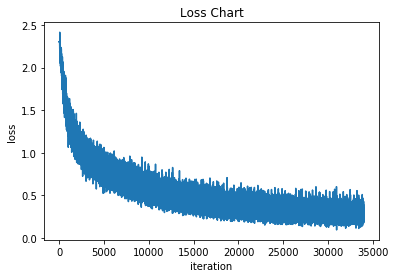

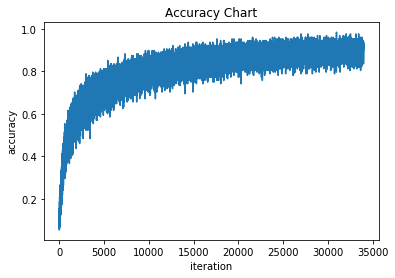

validation for epoch 88
-  epoch 88: validation accuracy = 0.831
train for epoch 89
iteration (34000): loss = 0.281, accuracy = 0.898
iteration (34050): loss = 0.252, accuracy = 0.883
iteration (34100): loss = 0.249, accuracy = 0.891
iteration (34150): loss = 0.375, accuracy = 0.867
iteration (34200): loss = 0.379, accuracy = 0.867
iteration (34250): loss = 0.179, accuracy = 0.945
iteration (34300): loss = 0.269, accuracy = 0.891
iteration (34350): loss = 0.214, accuracy = 0.938


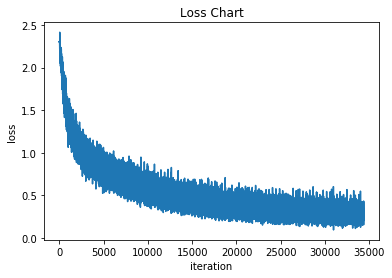

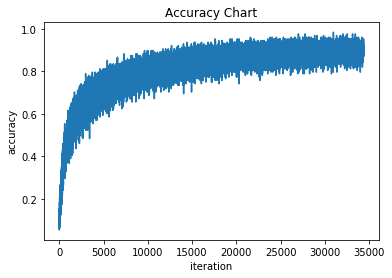

validation for epoch 89
-  epoch 89: validation accuracy = 0.828
train for epoch 90
iteration (34400): loss = 0.116, accuracy = 0.953
iteration (34450): loss = 0.313, accuracy = 0.867
iteration (34500): loss = 0.286, accuracy = 0.930
iteration (34550): loss = 0.247, accuracy = 0.891
iteration (34600): loss = 0.247, accuracy = 0.898
iteration (34650): loss = 0.279, accuracy = 0.914
iteration (34700): loss = 0.335, accuracy = 0.867
iteration (34750): loss = 0.257, accuracy = 0.906


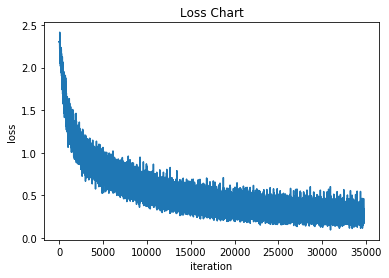

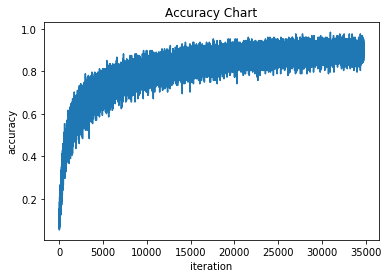

validation for epoch 90
-  epoch 90: validation accuracy = 0.830
train for epoch 91
iteration (34800): loss = 0.385, accuracy = 0.898
iteration (34850): loss = 0.321, accuracy = 0.867
iteration (34900): loss = 0.301, accuracy = 0.898
iteration (34950): loss = 0.255, accuracy = 0.883
iteration (35000): loss = 0.334, accuracy = 0.898
iteration (35050): loss = 0.275, accuracy = 0.898
iteration (35100): loss = 0.322, accuracy = 0.891


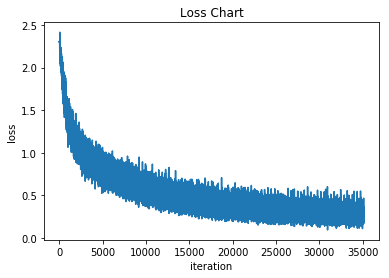

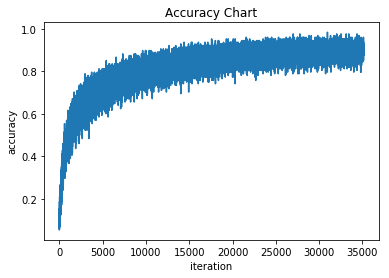

validation for epoch 91
-  epoch 91: validation accuracy = 0.830
train for epoch 92
iteration (35150): loss = 0.333, accuracy = 0.875
iteration (35200): loss = 0.214, accuracy = 0.922
iteration (35250): loss = 0.396, accuracy = 0.844
iteration (35300): loss = 0.349, accuracy = 0.891
iteration (35350): loss = 0.197, accuracy = 0.914
iteration (35400): loss = 0.364, accuracy = 0.852
iteration (35450): loss = 0.312, accuracy = 0.875
iteration (35500): loss = 0.283, accuracy = 0.898


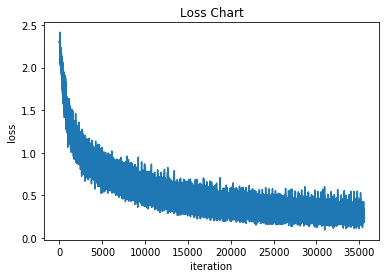

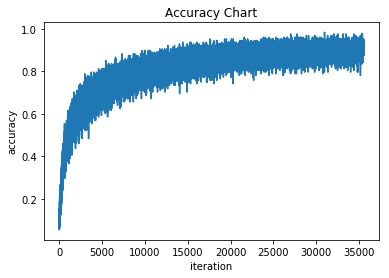

validation for epoch 92
-  epoch 92: validation accuracy = 0.829
train for epoch 93
iteration (35550): loss = 0.266, accuracy = 0.898
iteration (35600): loss = 0.189, accuracy = 0.938
iteration (35650): loss = 0.373, accuracy = 0.867
iteration (35700): loss = 0.234, accuracy = 0.938
iteration (35750): loss = 0.282, accuracy = 0.898
iteration (35800): loss = 0.243, accuracy = 0.938
iteration (35850): loss = 0.309, accuracy = 0.891
iteration (35900): loss = 0.334, accuracy = 0.875


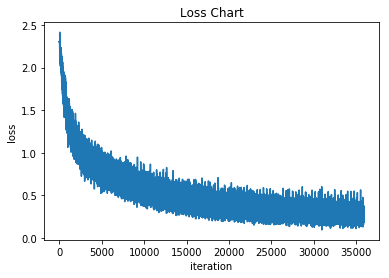

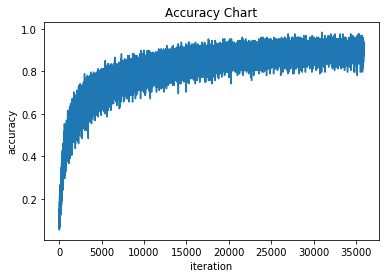

validation for epoch 93
-  epoch 93: validation accuracy = 0.836
train for epoch 94
iteration (35950): loss = 0.310, accuracy = 0.867
iteration (36000): loss = 0.313, accuracy = 0.852
iteration (36050): loss = 0.344, accuracy = 0.875
iteration (36100): loss = 0.310, accuracy = 0.883
iteration (36150): loss = 0.359, accuracy = 0.906
iteration (36200): loss = 0.265, accuracy = 0.945
iteration (36250): loss = 0.294, accuracy = 0.898


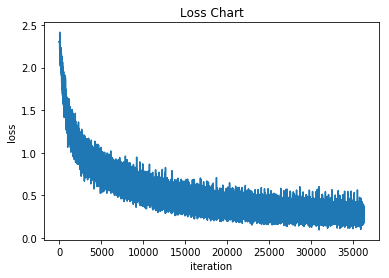

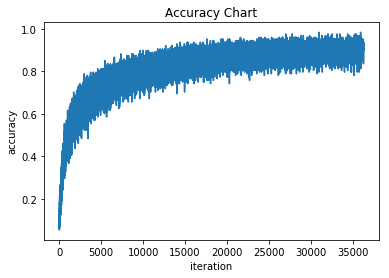

validation for epoch 94
-  epoch 94: validation accuracy = 0.834
train for epoch 95
iteration (36300): loss = 0.329, accuracy = 0.875
iteration (36350): loss = 0.208, accuracy = 0.938
iteration (36400): loss = 0.360, accuracy = 0.875
iteration (36450): loss = 0.326, accuracy = 0.883
iteration (36500): loss = 0.310, accuracy = 0.891
iteration (36550): loss = 0.329, accuracy = 0.906
iteration (36600): loss = 0.329, accuracy = 0.883
iteration (36650): loss = 0.178, accuracy = 0.938


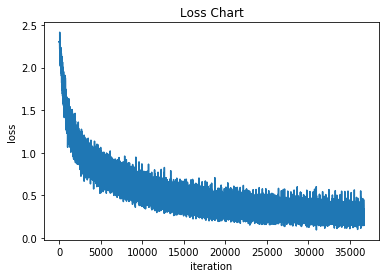

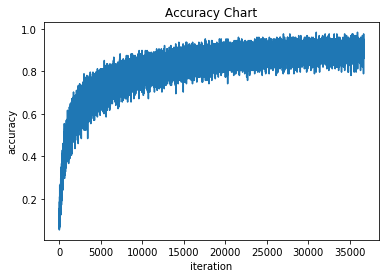

validation for epoch 95
-  epoch 95: validation accuracy = 0.834
train for epoch 96
iteration (36700): loss = 0.176, accuracy = 0.953
iteration (36750): loss = 0.183, accuracy = 0.930
iteration (36800): loss = 0.342, accuracy = 0.883
iteration (36850): loss = 0.304, accuracy = 0.914
iteration (36900): loss = 0.204, accuracy = 0.922
iteration (36950): loss = 0.216, accuracy = 0.953
iteration (37000): loss = 0.306, accuracy = 0.891
iteration (37050): loss = 0.151, accuracy = 0.969


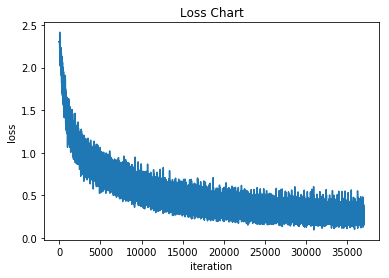

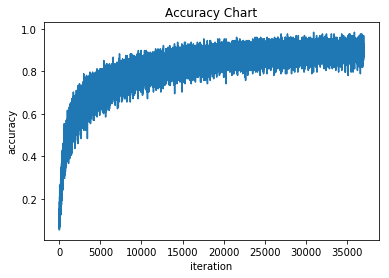

validation for epoch 96
-  epoch 96: validation accuracy = 0.830
train for epoch 97
iteration (37100): loss = 0.206, accuracy = 0.930
iteration (37150): loss = 0.323, accuracy = 0.867
iteration (37200): loss = 0.216, accuracy = 0.906
iteration (37250): loss = 0.252, accuracy = 0.906
iteration (37300): loss = 0.264, accuracy = 0.906
iteration (37350): loss = 0.222, accuracy = 0.922
iteration (37400): loss = 0.194, accuracy = 0.922


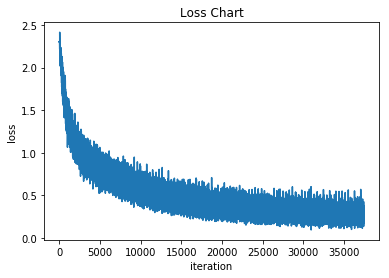

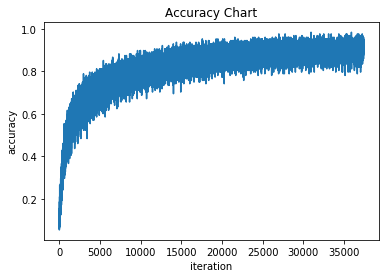

validation for epoch 97
-  epoch 97: validation accuracy = 0.834
train for epoch 98
iteration (37450): loss = 0.222, accuracy = 0.914
iteration (37500): loss = 0.259, accuracy = 0.898
iteration (37550): loss = 0.257, accuracy = 0.906
iteration (37600): loss = 0.214, accuracy = 0.914
iteration (37650): loss = 0.280, accuracy = 0.914
iteration (37700): loss = 0.277, accuracy = 0.883
iteration (37750): loss = 0.196, accuracy = 0.953
iteration (37800): loss = 0.244, accuracy = 0.906


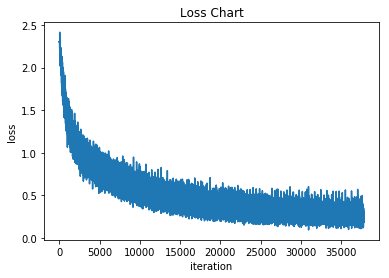

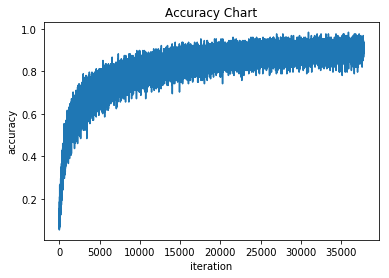

validation for epoch 98
-  epoch 98: validation accuracy = 0.833
train for epoch 99
iteration (37850): loss = 0.323, accuracy = 0.883
iteration (37900): loss = 0.210, accuracy = 0.922
iteration (37950): loss = 0.226, accuracy = 0.930
iteration (38000): loss = 0.253, accuracy = 0.906
iteration (38050): loss = 0.227, accuracy = 0.914
iteration (38100): loss = 0.294, accuracy = 0.883
iteration (38150): loss = 0.249, accuracy = 0.898


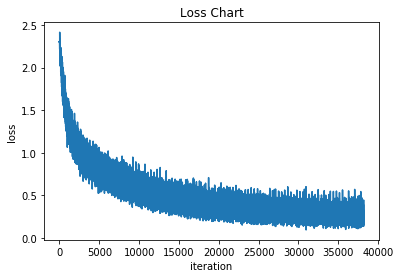

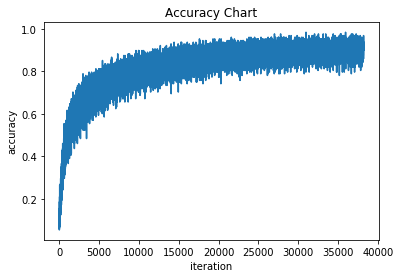

validation for epoch 99
-  epoch 99: validation accuracy = 0.835
***** test accuracy: 0.827
Model saved in lib/tf_models/problem2/csci-599_mine.ckpt


In [9]:
# Clear old computation graphs
tf.reset_default_graph()

#sess = tf.Session()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "problem2/csci-599_mine.ckpt")
#############################################################################
# TODO: Preprocessing                                                       #
#############################################################################
X_train_ = normalize(X_train)
X_val_ = normalize(X_val)
X_test_ = normalize(X_test)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

#model = YourModel()
model.train(sess, X_train_, Y_train, X_val_, Y_val)
accuracy = model.evaluate(sess, X_test_, Y_test)
print('***** test accuracy: %.3f' % accuracy)

# Save your model
saver = tf.train.Saver()
model_path = saver.save(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")
print("Model saved in %s" % model_path)

sess.close()

In [10]:
tf.reset_default_graph()

# Load your model
model = YourModel()
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "lib/tf_models/problem2/csci-599_mine.ckpt")

-----  Your model  -----
intput layer: (?, 32, 32, 3)
conv1 layer: (?, 32, 32, 192)
conv2 layer: (?, 32, 32, 160)
conv3 layer: (?, 16, 16, 96)
conv4 layer: (?, 16, 16, 192)
conv5 layer: (?, 16, 16, 192)
conv6 layer: (?, 8, 8, 192)
conv7 layer: (?, 8, 8, 192)
conv8 layer: (?, 8, 8, 192)
conv9 layer: (?, 1, 1, 10)
